In [95]:
from config import settings
from hannover_pylon.data import datamodules as dm
from pathlib import Path
from hannover_pylon.modelling.transformation import FromBuffer , CutPSD , DirectionEncoder,LevelEncoder , NormLayer
import matplotlib.pyplot as plt
from torch import nn 

In [96]:
import numpy as np
freq_axis = np.linspace(0, 825.5, 8197)
db_path = Path(settings.path.processed,'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')


In [97]:
from hannover_pylon.data import datamodules_pivot as dm
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = f'''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel" AND date BETWEEN '{settings.state.healthy_train.start}' AND '{settings.state.healthy_train.end}'
    AND corrupted = 0
    ORDER BY date
    
'''
columns = ['psd', 'level', 'direction']
transform_func = [nn.Sequential(FromBuffer(),CutPSD(freq_axis=freq_axis,freq_range=(0,150)),NormLayer(max_val = 4.96, min_val = -5.46, denormalize=False)), 
                  nn.Identity(),nn.Identity()]

# Initialize DataModule
data_module = dm.PSDDataModule(
    db_path=db_path,
    query_key=query_key,
    columns=columns,
    transform_func=transform_func,
    batch_size=32,
    num_workers=16,
    return_dict=True
)
data_module.setup()


In [98]:
import torch 
for batch in data_module.train_dataloader():
    print(torch.stack(batch['psd']).shape)
    input_dim = torch.stack(batch['psd']).shape[-1]
    # check max and min values
    print(torch.stack(batch['psd']).max())
    print(torch.stack(batch['psd']).min())
    break
for batch in data_module.val_dataloader():
    print(torch.stack(batch['psd']).shape)
    break

torch.Size([32, 18, 1490])
tensor(0.8654)
tensor(0.0204)
torch.Size([32, 18, 1490])


In [99]:
def random_masking(x, mask_ratio=0.8):
    """
    Perform per-sample random masking by shuffling sensors.
    Args:
        x (torch.Tensor): Input tensor of shape [B, S, F],
                          where B is batch size, S is number of sensors, F is feature dimension.
        mask_ratio (float): Fraction of sensors to mask (e.g., 0.8 masks 80% of sensors).
    Returns:
        x_masked (torch.Tensor): Masked tensor with only unmasked sensors retained.
        mask (torch.Tensor): Binary mask of shape [B, S], 0 for kept sensors, 1 for masked sensors.
        ids_restore (torch.Tensor): Indices to restore the original order.
    """
    B, S, F = x.shape
    len_keep = int(S * (1 - mask_ratio))  # Number of sensors to keep

    # Generate random indices for each sample in the batch
    ids_shuffle = torch.stack([torch.randperm(S, device=x.device) for _ in range(B)])
    ids_restore = torch.argsort(ids_shuffle, dim=1)  # Indices to restore the original order

    # Select indices to keep
    ids_keep = ids_shuffle[:, :len_keep]
    x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).expand(-1, -1, F))

    # Create binary mask: 0 for kept sensors, 1 for masked sensors
    mask = torch.ones([B, S], device=x.device, dtype=torch.bool)
    mask[:, :len_keep] = False  # Set unmasked positions to False
    mask = torch.gather(mask, dim=1, index=ids_restore)

    return x_masked, mask, ids_restore



In [100]:
import numpy as np

def random_indexes(size: int):
    """
    Generate random forward and backward indices for shuffling and restoring order.
    Args:
        size (int): Number of elements to shuffle.
    Returns:
        forward_indexes (np.ndarray): Shuffled indices for forward transformation.
        backward_indexes (np.ndarray): Indices to restore the original order.
    """
    forward_indexes = np.arange(size)  # Create a sequence of indice+s [0, 1, 2, ..., size-1]
    np.random.shuffle(forward_indexes)  # Shuffle the indices randomly
    backward_indexes = np.argsort(forward_indexes)  # Compute indices to restore the original order
    return forward_indexes, backward_indexes


In [101]:
def take_indexes(sequences, indexes):
    """
    Gather elements from sequences based on provided indices.
    Args:
        sequences (torch.Tensor): Input tensor of shape [B, S, F].
        indexes (torch.Tensor): Indices tensor of shape [B, S] specifying the elements to gather.
    Returns:
        torch.Tensor: Gathered tensor with elements rearranged according to indexes.
    """
    return torch.gather(sequences, dim=1, index=indexes.unsqueeze(-1).expand(-1, -1, sequences.shape[-1]))


In [102]:
class PatchShuffle(torch.nn.Module):
    def __init__(self, ratio) -> None:
        super().__init__()
        self.ratio = ratio

    def forward(self, patches: torch.Tensor):
        B, S, F = patches.shape
        remain_T = int(S * (1 - self.ratio))

        # Generate forward and backward indexes for each batch
        indexes = [random_indexes(S) for _ in range(B)]
        forward_indexes = torch.as_tensor(np.stack([i[0] for i in indexes], axis=0), dtype=torch.long).to(patches.device)
        backward_indexes = torch.as_tensor(np.stack([i[1] for i in indexes], axis=0), dtype=torch.long).to(patches.device)

        # Apply forward indexes to shuffle and select a subset of patches
        patches = take_indexes(patches, forward_indexes)
        patches = patches[:, :remain_T, :]  # Mask patches based on remain_T

        return patches, forward_indexes, backward_indexes


In [103]:
# Simulated input tensor
B, S, F = 32, 18, 512  # Batch size, number of sensors, feature dimension
patches = torch.rand(B, S, F)

# Initialize and apply PatchShuffle
shuffle = PatchShuffle(ratio=0.8)
masked_patches, forward_indexes, backward_indexes = shuffle(patches)

print("Original Shape:", patches.shape)  # (4, 10, 8)
print("Masked Shape:", masked_patches.shape)  # (4, 2, 8) - 20% kept
print("Forward Indexes Shape:", forward_indexes.shape)  # (4, 10)
print("Backward Indexes Shape:", backward_indexes.shape)  # (4, 10)


Original Shape: torch.Size([32, 18, 512])
Masked Shape: torch.Size([32, 3, 512])
Forward Indexes Shape: torch.Size([32, 18])
Backward Indexes Shape: torch.Size([32, 18])


In [ ]:
import torch
from torch import nn

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=5):
        """
        A single Transformer block.
        Args:
            dim (int): Input and output dimension.
            num_heads (int): Number of attention heads.
            mlp_ratio (float): Ratio of hidden dimension to input dimension in the MLP.
            dropout (float): Dropout rate.
        """
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads)

        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.ReLU(),
            nn.Linear(int(dim * mlp_ratio), dim),
        )

    def forward(self, x):
        # x: [batch_size, seq_len, dim]
        x = self.attn(x, x, x)[0]  # MHSA 
        x = self.mlp(x) # FFN 
        return x


In [109]:
import torch.nn.init as init
from einops import rearrange


class MAE_Encoder(nn.Module):
    def __init__(self, 
                 num_sensors=18, 
                 feature_dim=512,  # Set this to your actual feature dimension F
                 emb_dim=128, 
                 num_layers=6, 
                 num_heads=4, 
                 mask_ratio=0.75):
        super().__init__()
        self.num_sensors = num_sensors
        self.mask_ratio = mask_ratio
        self.feature_dim = feature_dim

        # Embedding layer
        self.embedding = nn.Linear(feature_dim, emb_dim)
        
        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_sensors, emb_dim))
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

        # Mask token (for masked positions)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        nn.init.trunc_normal_(self.mask_token, std=0.02)

        # Transformer encoder
        self.encoder_layers = nn.ModuleList([
            Block(emb_dim, num_heads) for _ in range(num_layers)
        ])

        # Layer normalization

    def forward(self, x):
        # x: [B, S, F]
        B, S, F = x.shape

        # Embed sensor readings
        x = self.embedding(x)  # [B, S, emb_dim]

        # Add positional embeddings
        x = x + self.pos_embedding[:, :S, :]

        # Masking
        x, mask, ids_restore = random_masking(x, self.mask_ratio)  # x: [B, S_masked, emb_dim]

        # Apply transformer encoder
        for blk in self.encoder_layers:
            x = blk(x)


        return x, mask, ids_restore



In [113]:
class MAE_Decoder(nn.Module):
    def __init__(self, 
                 num_sensors=18, 
                 feature_dim=512,  # Same as in encoder
                 emb_dim=128, 
                 num_layers=4, 
                 num_heads=4):
        super().__init__()
        self.num_sensors = num_sensors
        self.feature_dim = feature_dim

        # Mask token (used for masked positions)
        self.mask_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        nn.init.trunc_normal_(self.mask_token, std=0.02)

        # Positional encoding
        self.pos_embedding = nn.Parameter(torch.zeros(1, num_sensors, emb_dim))
        nn.init.trunc_normal_(self.pos_embedding, std=0.02)

        # Transformer decoder
        self.decoder_layers = nn.ModuleList([
            Block(emb_dim, num_heads) for _ in range(num_layers)
        ])

        # Layer normalization

        # Output layer
        self.output_layer = nn.Linear(emb_dim, feature_dim)  # Map back to feature dimension

    def forward(self, x, ids_restore):
        # x: [B, S_masked, emb_dim]
        B, S_masked, emb_dim = x.shape
        S = self.num_sensors

        # Prepare tokens
        mask_tokens = self.mask_token.repeat(B, S - S_masked, 1)  # [B, S_masked_missing, emb_dim]
        x_ = torch.cat([x, mask_tokens], dim=1)  # [B, S, emb_dim]

        # Unshuffle
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).expand(-1, -1, emb_dim))

        # Add positional embeddings
        x_ = x_ + self.pos_embedding

        # Apply transformer decoder
        for blk in self.decoder_layers:
            x_ = blk(x_)

        # Predict sensor readings
        output = self.output_layer(x_)  # [B, S, feature_dim]

        return output


In [118]:
import pytorch_lightning as pl
import torch.nn.functional as Func
class MAE_Model(pl.LightningModule):
    def __init__(self, 
                 feature_dim=512,
                 num_sensors=18, 
                 emb_dim=8, 
                 encoder_layers=10, 
                 decoder_layers=4, 
                 num_heads=2, 
                 mask_ratio=0.75, 
                 learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.encoder = MAE_Encoder(
            feature_dim=feature_dim,
            num_sensors=num_sensors,
            emb_dim=emb_dim,
            num_layers=encoder_layers,
            num_heads=num_heads,
            mask_ratio=mask_ratio
        )

        self.decoder = MAE_Decoder(
            feature_dim=feature_dim,
            num_sensors=num_sensors,
            emb_dim=emb_dim,
            num_layers=decoder_layers,
            num_heads=num_heads
        )

    def forward(self, x):
        # x: [B, S]
        x_encoded, mask, ids_restore = self.encoder(x)
        x_decoded = self.decoder(x_encoded, ids_restore)
        return x_decoded, mask

    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # [B, S, F]
        x = x.squeeze(-1)  # If necessary, adjust to [B, S]
        x_decoded, mask = self(x)
        x_true = x

        # Compute loss on masked positions
        loss = Func.mse_loss(x_decoded, x_true)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])
        x = x.squeeze(-1)
        x_decoded, mask = self(x)
        x_true = x
        
        # Compute loss on masked positions
        loss = Func.mse_loss(x_decoded, x_true)
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)
        return optimizer


In [121]:
# Instantiate the model
model = MAE_Model(
    feature_dim=input_dim,
    num_sensors=18,
    emb_dim=8,
    encoder_layers=10,
    decoder_layers=4,
    num_heads=1,
    mask_ratio=0.9,
    learning_rate=1e-3
)

# Trainer
trainer = pl.Trainer(
    max_epochs=10)

# Train the model
trainer.fit(model, data_module)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type        | Params | Mode 
------------------------------------------------
0 | encoder | MAE_Encoder | 20.5 K | train
1 | decoder | MAE_Decoder | 16.9 K | train
------------------------------------------------
37.4 K    Trainable params
0         Non-trainable params
37.4 K    Total params
0.150     Total estimated model params size (MB)
104       Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 219/219 [00:06<00:00, 32.52it/s, v_num=107, train_loss_step=0.0101, val_loss_step=0.00864, val_loss_epoch=0.0105, train_loss_epoch=0.0101] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 219/219 [00:06<00:00, 32.44it/s, v_num=107, train_loss_step=0.0101, val_loss_step=0.00864, val_loss_epoch=0.0105, train_loss_epoch=0.0101]


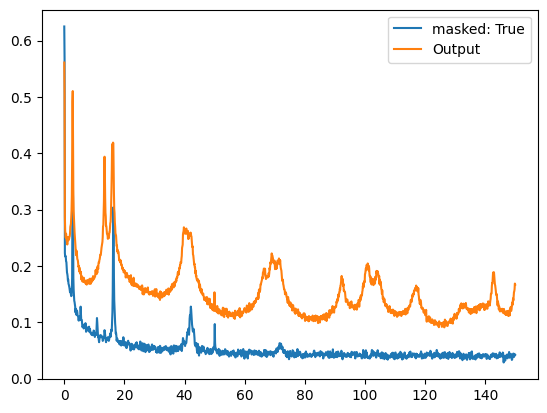

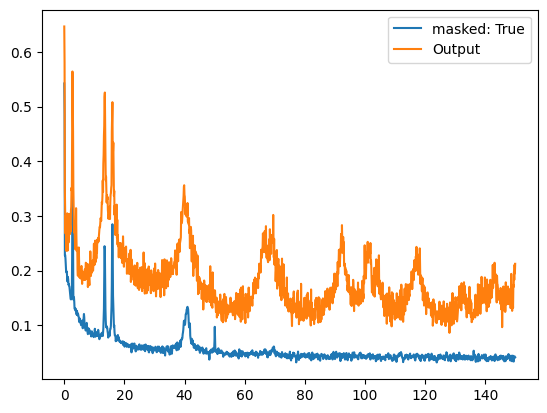

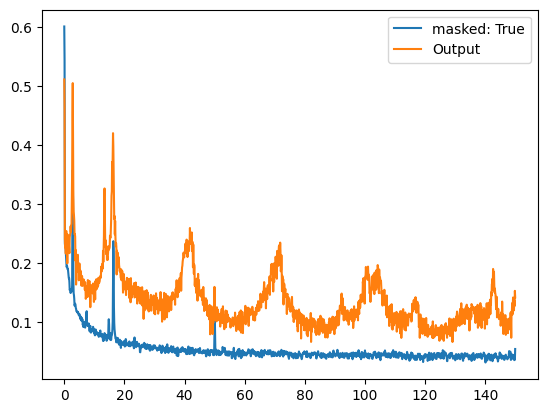

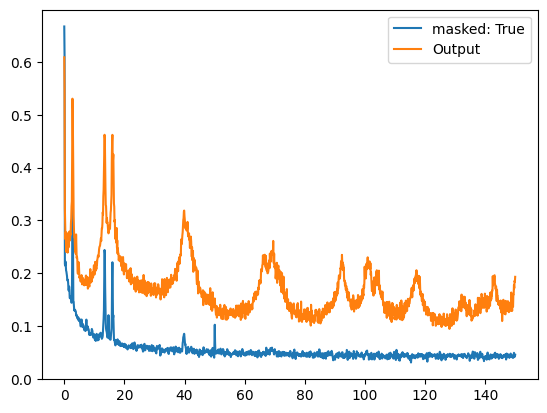

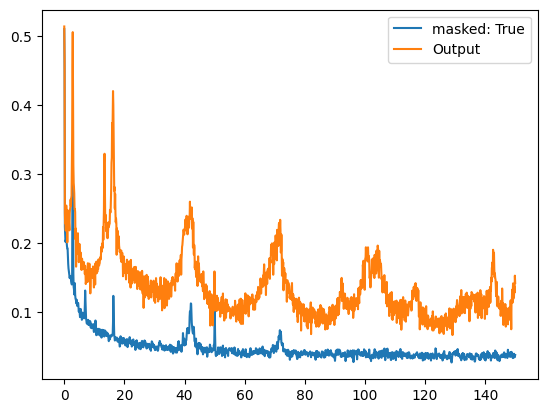

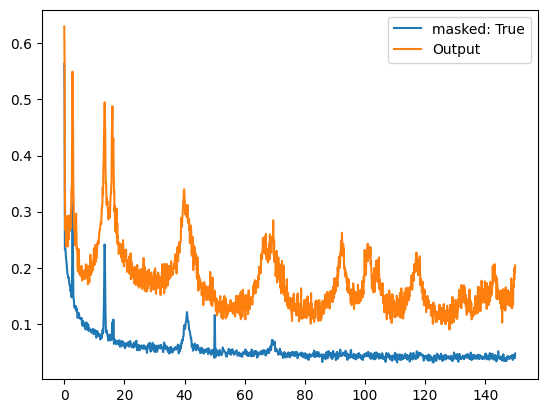

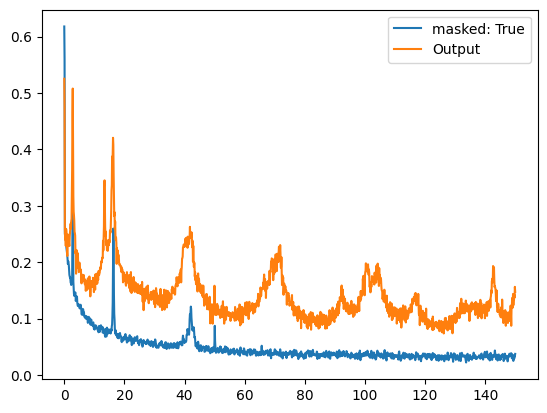

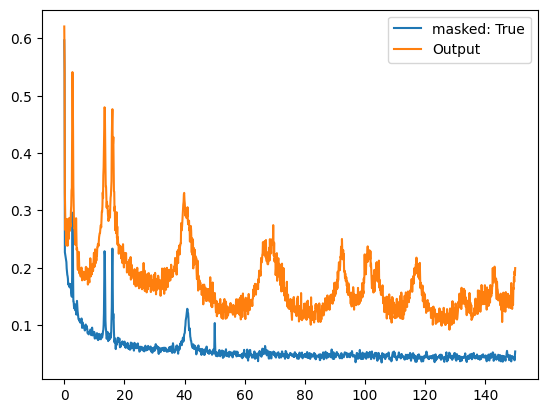

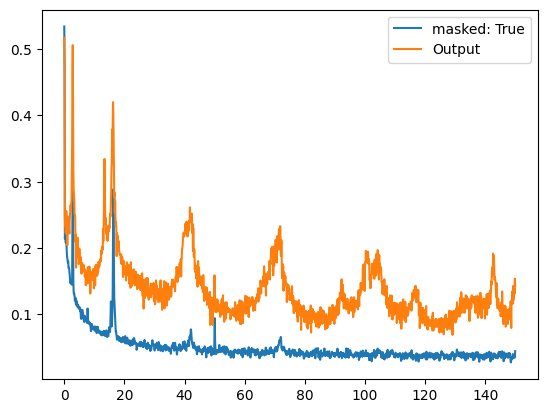

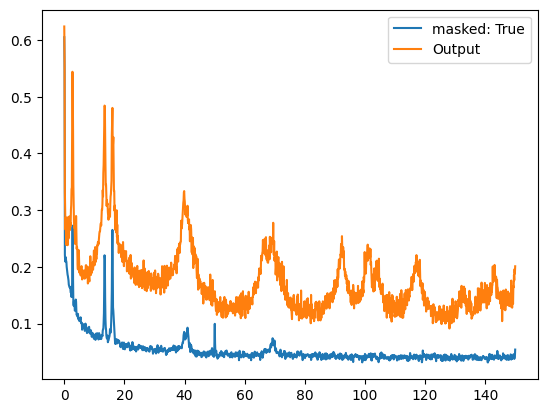

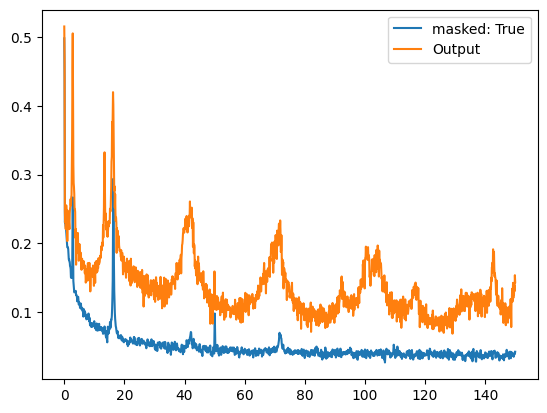

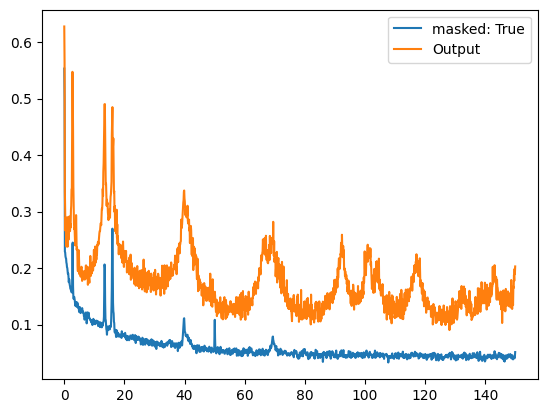

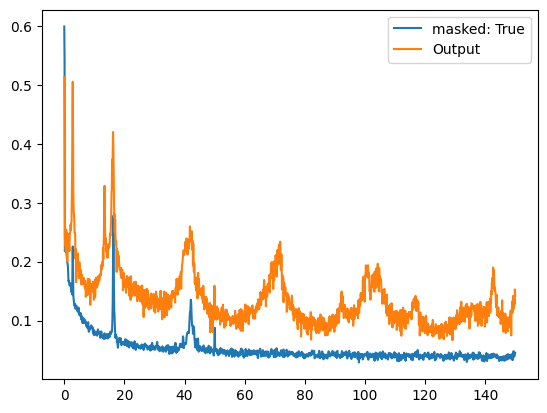

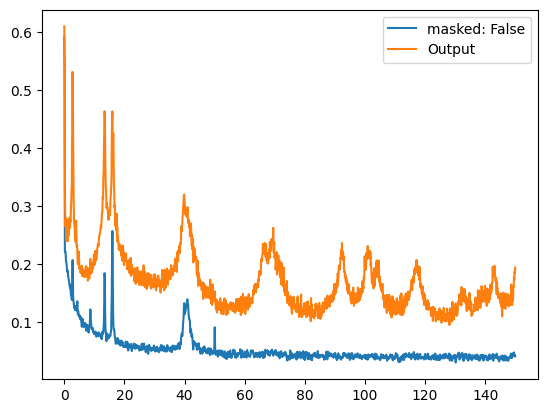

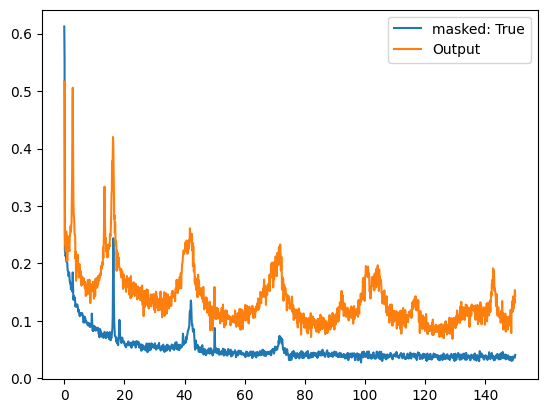

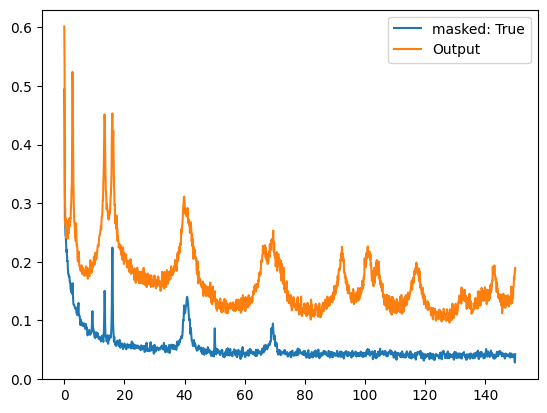

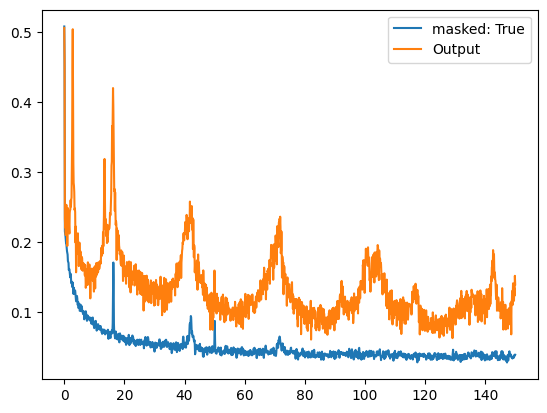

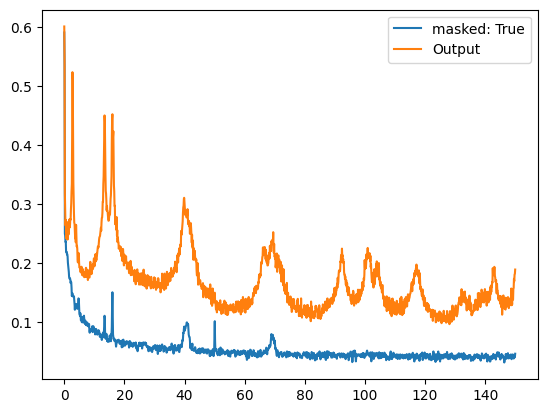

In [122]:
# let's plot one example of the input and output of the model to see how well it is doing
model.eval()
# Get a batch of data
batch = next(iter(data_module.val_dataloader()))

# Extract the PSD data
x = torch.stack(batch['psd'])
x = x.squeeze(-1)  # Adjust to [B, S]

# Forward passµ
x_decoded, mask = model(x)
psds_in = x[5]
psds_out = x_decoded[5] 
masked = mask[5]
for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:input_dim], psds_in[i].detach().numpy(), label= f'masked: {masked[i]}')
    plt.plot(freq_axis[0:input_dim], psds_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()





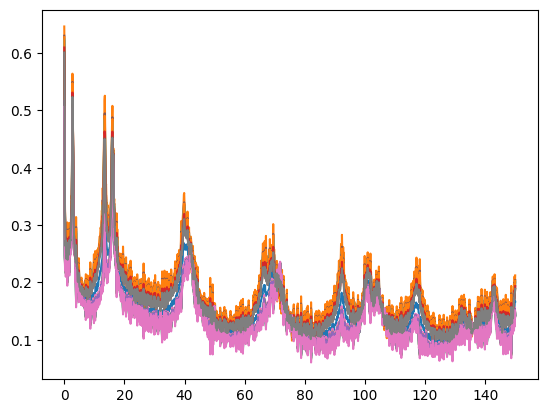

In [123]:
plt.plot(freq_axis[0:input_dim], psds_out.T.detach().numpy(), label='Input')

In [124]:
# let's implement this but with simple dense layers 

class Encoder(nn.Module):
    def __init__(self, input_dim: int, emb_dim: int, hidden_layers: list[int]):
        super(Encoder, self).__init__()
        self.build_encoder(input_dim, emb_dim, hidden_layers)
        
    def build_encoder(self, input_dim: int, emb_dim: int, hidden_layers: list[int]):
        layers = []
        in_dim = input_dim
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim  # Update in_dim for the next layer
        layers.append(nn.Linear(in_dim, emb_dim))  # Output layer maps to emb_dim
        self.layers = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.layers(x)
        return x

    
class PositionalEmbedding(nn.Module):
    def __init__(self, emb_dim:int,num_sensors:int):
        super(PositionalEmbedding, self).__init__()
        self.positional_embedding = nn.Parameter(torch.zeros(1,num_sensors,emb_dim))
        nn.init.trunc_normal_(self.positional_embedding,std=0.02)
        
    def forward(self,x):
        x = x + self.positional_embedding
        return x
    
class Decoder(nn.Module):
    def __init__(self, emb_dim: int, hidden_layers: list, output_dim: int, num_sensors: int):
        super(Decoder, self).__init__()
        self.num_sensors = num_sensors
        self.emb_dim = emb_dim
        self.output_dim = output_dim
        self.build_decoder(hidden_layers)
    
    def build_decoder(self, hidden_layers: list):
        # Define the layers before the last layer
        layers = []
        in_dim = self.emb_dim * self.num_sensors
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(in_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            in_dim = hidden_dim
        
        # Assign the shared layers to self.layers
        self.layers = nn.Sequential(*layers)
        
        # Define the output layer per sensor
        self.output_layers = nn.ModuleList([
            nn.Linear(hidden_dim, self.output_dim) for _ in range(self.num_sensors)
        ])
    
    def forward(self, x):
        # x shape: [B, S * emb_dim]
        # Pass through shared layers
        x = self.layers(x)  # [B, hidden_dim]
        
        outputs = []
        for i in range(self.num_sensors):
            output = self.output_layers[i](x)  # [B, output_dim]
            outputs.append(output)  # [B, 1, output_dim]
        
        # Concatenate outputs along the sensor dimension
        x = torch.cat(outputs, dim=1)  # [B, S, output_dim]
        return x

    
    

In [125]:

import torch
import torch.nn as nn

class PositionalEmbeddingTR(nn.Module):
    def __init__(self, seq_len, emb_dim):
        super(PositionalEmbeddingTR, self).__init__()
        self.positional_embedding = nn.Parameter(torch.zeros(1, seq_len, emb_dim))
        nn.init.trunc_normal_(self.positional_embedding, std=0.02)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, emb_dim]
        x = x + self.positional_embedding  # Broadcasted addition
        return x



class TransformerDecoder(nn.Module):
    def __init__(self, emb_dim, num_layers, nhead, dim_feedforward, output_dim):
        super(TransformerDecoder, self).__init__()
        self.positional_encoding = PositionalEmbeddingTR(emb_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_linear = nn.Linear(emb_dim, output_dim)

    def forward(self, x_encoded_masked):
        # x_encoded_masked shape: [batch_size, seq_len, emb_dim]
        x = self.positional_encoding(x_encoded_masked)
        x = x.permute(1, 0, 2)  # Shape: [seq_len, batch_size, emb_dim]
        output = self.transformer_encoder(x)
        output = output.permute(1, 0, 2)  # Shape: [batch_size, seq_len, emb_dim]
        output = self.output_linear(output)  # Shape: [batch_size, seq_len, output_dim]
        return output

In [126]:
import pytorch_lightning as pl
import torch.nn.functional as F

class MAE(pl.LightningModule):
    def __init__(self, input_dim, emb_dim, num_sensors, encoder_hidden_layers, decoder_hidden_layers, learning_rate=1e-3, mask_ratio=0.8):
        super(MAE, self).__init__()
        self.save_hyperparameters()
        
        self.num_sensors = num_sensors
        self.emb_dim = emb_dim
        self.mask_ratio = mask_ratio
        self.learning_rate = learning_rate
        
        # Instantiate the encoder, positional embedding, and decoder
        self.encoder = Encoder(input_dim, emb_dim, encoder_hidden_layers)
        self.decoder = Decoder(emb_dim , decoder_hidden_layers, 
                               output_dim=input_dim, num_sensors = num_sensors)
        self.positional_embedding = PositionalEmbedding(emb_dim, num_sensors)
        # Mask token for masked positions
        self.mask_token = nn.Parameter(torch.zeros(1, 1, emb_dim))
        nn.init.trunc_normal_(self.mask_token, std=0.02)
        

    
 
    def forward(self, x, sensor_mask=None):
        # x: [B, S, F]
        B, S, F = x.shape

        # Flatten batch and sensor dimensions for encoding
        x_flat = x.view(B * S, F)  # [B*S, F]
        x_encoded = self.encoder(x_flat)  # [B*S, emb_dim]
        x_encoded = x_encoded.view(B, S, self.emb_dim)  # [B, S, emb_dim]

        # Add positional embeddings if applicable
        # x_encoded = self.pos_embedding(x_encoded)  # [B, S, emb_dim]

        if sensor_mask is None:
            # Random mask during training
            sensor_mask = torch.rand(B, S, device=x.device) <= self.mask_ratio  # [B, S], boolean tensor
        else:
            # sensor_mask is a list of sensor indices
            mask = torch.zeros(S, dtype=torch.bool, device=x.device)
            mask[sensor_mask] = False  # Sensors provided
            sensor_mask = mask.unsqueeze(0).expand(B, S)  # [B, S]


        # Apply mask token to masked positions
        mask_expanded = (sensor_mask).unsqueeze(-1).expand_as(x_encoded)  # [B, S, emb_dim]
        x_encoded_masked = torch.where(mask_expanded, self.mask_token, x_encoded)  # [B, S, emb_dim]
    
        # Flatten embeddings for decoding
        x_encoded_flat = x_encoded_masked.view(B, -1)  # [B, S * emb_dim]

        # Decode to reconstruct input
        x_decoded_flat = self.decoder(x_encoded_flat)  # [B, S * F]
        x_decoded = x_decoded_flat.view(B, S, F)  # [B, S, F]
        return x_decoded, sensor_mask
    
        
    
    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # [B, S, F]
        x_decoded, mask = self(x)
        x_true = x
        
        # Compute loss on masked positions
        mask_expanded = mask.unsqueeze(-1).expand_as(x_true)  # [B, S, F]
        loss = F.mse_loss(x_decoded[mask_expanded], x_true[mask_expanded])
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # [B, S, F]
        x_decoded, mask = self(x)
        x_true = x
        
        # Compute loss on masked positions
        mask_expanded = mask.unsqueeze(-1).expand_as(x_true)  # [B, S, F]
        loss = F.mse_loss(x_decoded, x_true)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)


In [127]:
# Instantiate the model
model = MAE(
    input_dim=input_dim,
    emb_dim=6,
    num_sensors=18,
    encoder_hidden_layers=[512,512, 256,128],
    decoder_hidden_layers=[128,512,512],
    learning_rate=1e-3,
    mask_ratio=0.8
)
# Trainer
trainer = pl.Trainer(
    max_epochs=10)

# Train the model
trainer.fit(model, data_module)



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                | Params | Mode 
---------------------------------------------------------------------
0 | encoder              | Encoder             | 1.2 M  | train
1 | decoder              | Decoder             | 14.1 M | train
2 | positional_embedding | PositionalEmbedding | 108    | train
  | other params         | n/a                 | 6      | n/a  
---------------------------------------------------------------------
15.3 M    Trainable params
0         Non-trainable params
15.3 M    Total params
61.190    Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 219/219 [00:06<00:00, 34.80it/s, v_num=108, train_loss_step=0.00167, val_loss_step=0.00085, val_loss_epoch=0.00112, train_loss_epoch=0.00157] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 219/219 [00:06<00:00, 32.99it/s, v_num=108, train_loss_step=0.00167, val_loss_step=0.00085, val_loss_epoch=0.00112, train_loss_epoch=0.00157]


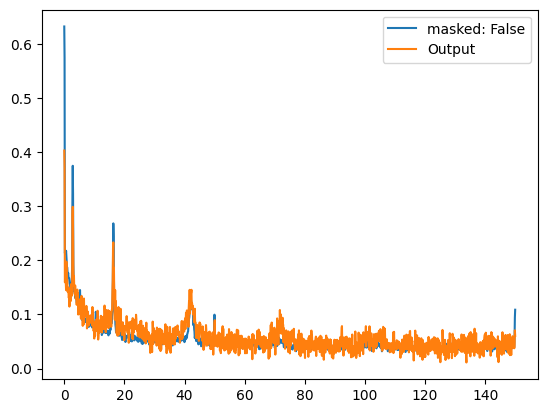

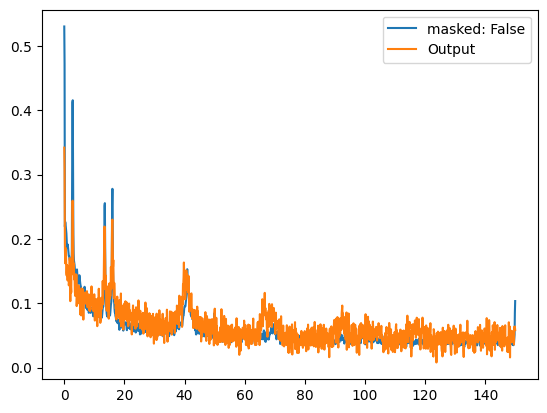

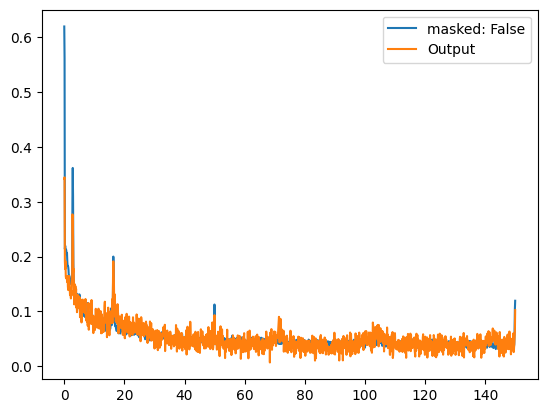

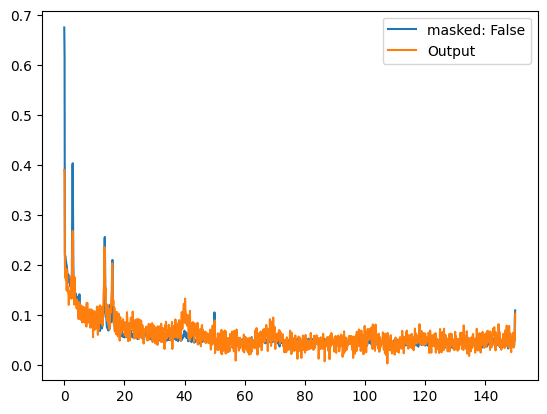

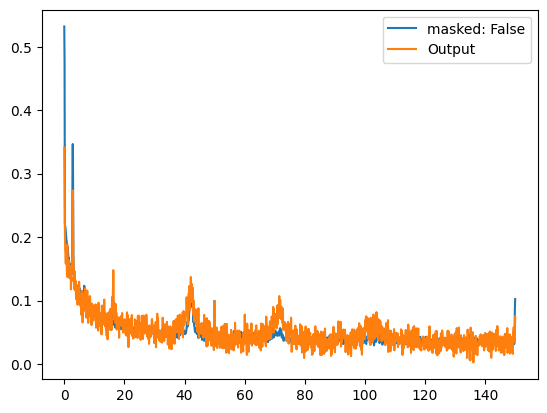

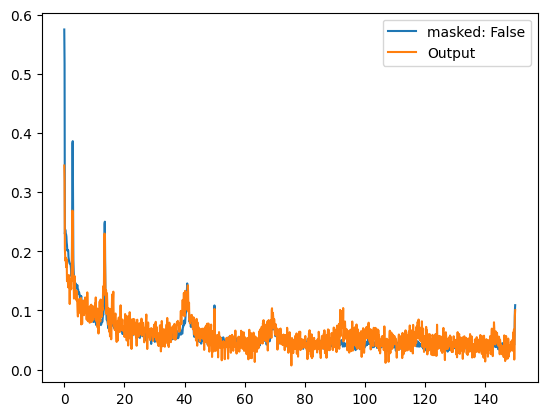

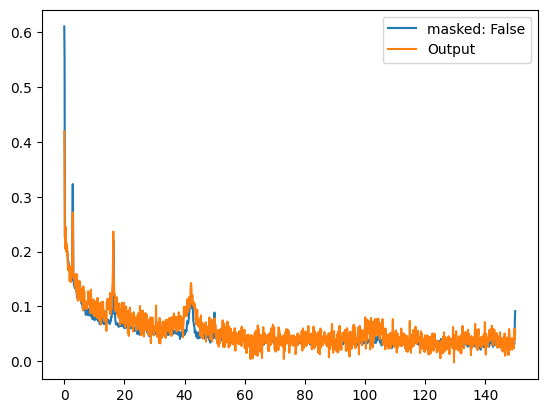

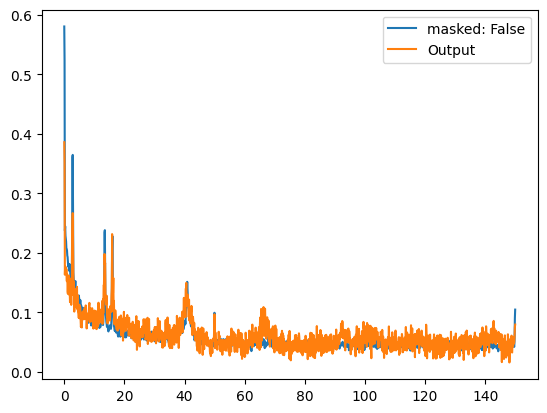

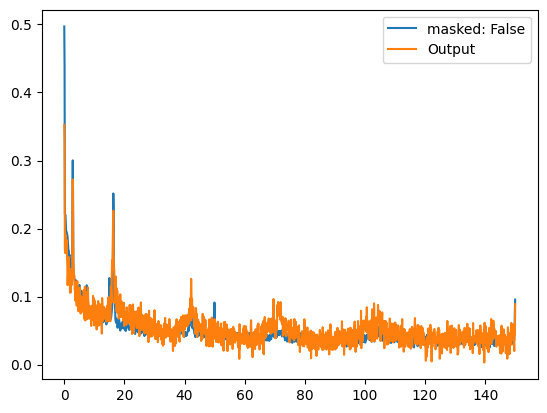

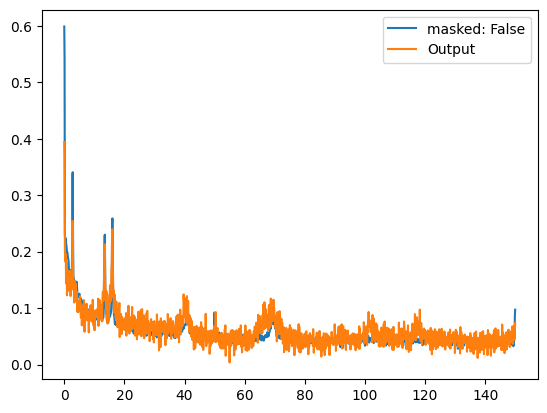

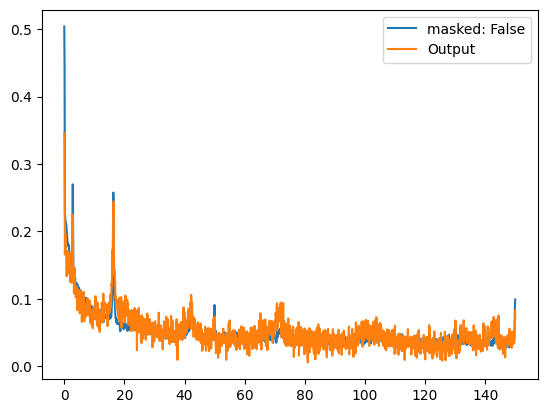

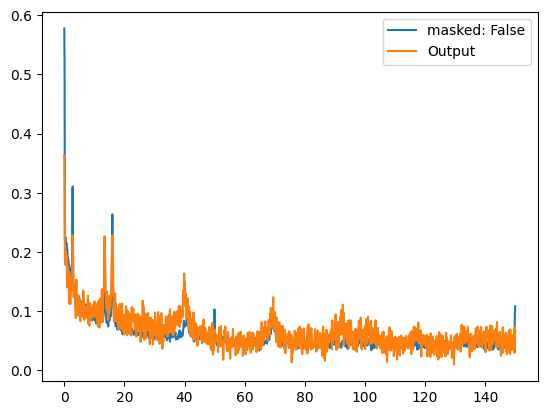

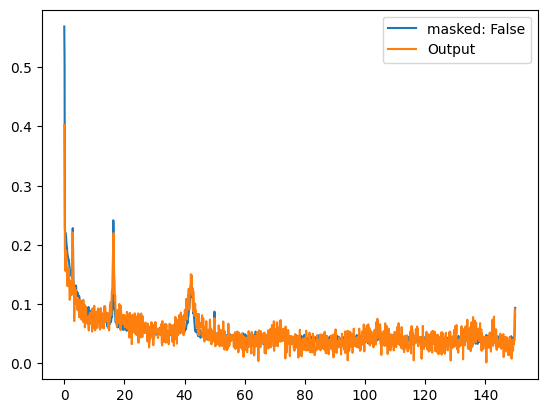

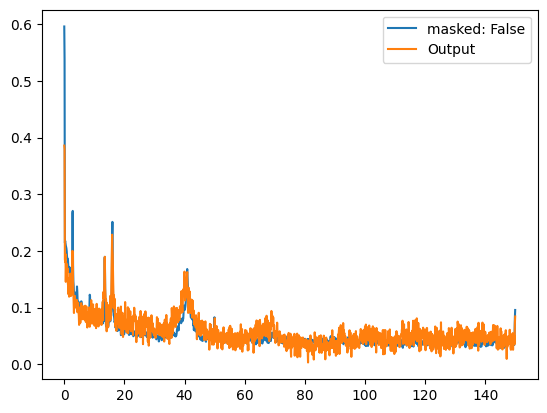

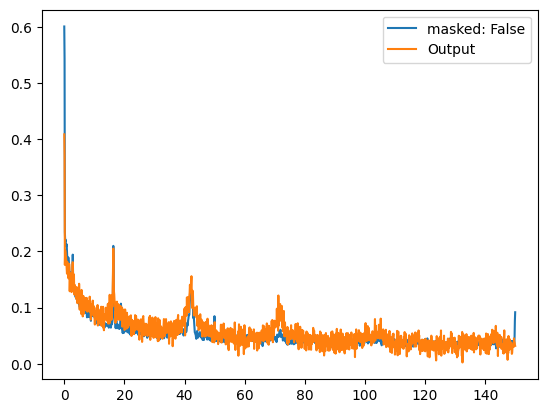

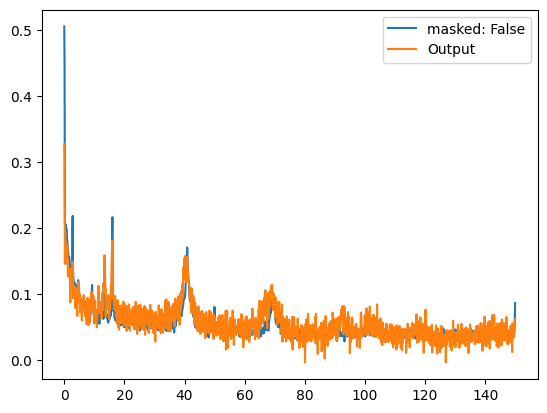

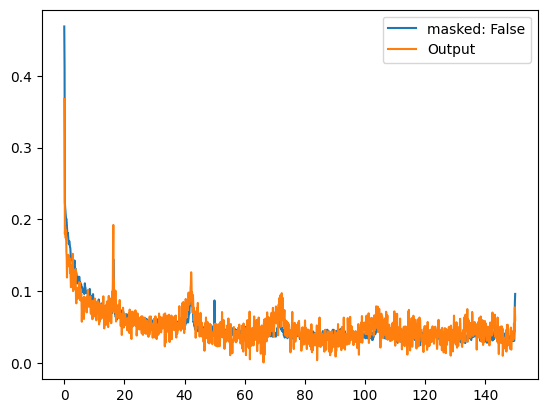

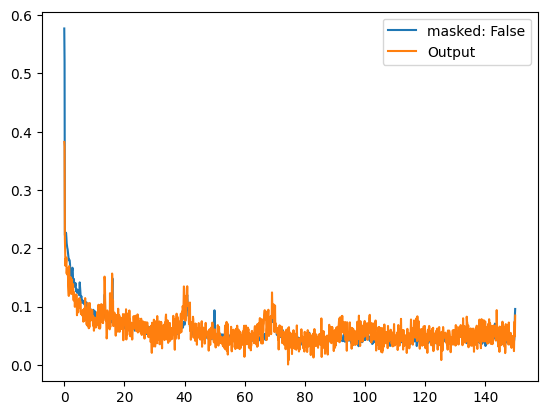

In [128]:
model.eval()
# Get a batch of data
batch = next(iter(data_module.val_dataloader()))
psd_in = torch.stack(batch['psd'])
psd_out,mask = model(psd_in, sensor_mask=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17])

psd_in = psd_in[5]
psd_out = psd_out[5]
mask = mask[5]


for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:input_dim], psd_in[i].detach().numpy(), label= f'masked: {mask[i]}')
    plt.plot(freq_axis[0:input_dim], psd_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()



In [129]:
import torch
import numpy as np
from hannover_pylon.data import datamodules as dm_no_pivot
# Update columns and transform_func to include 'level' or other labels
columns = ['psd', 'level', 'direction']  # Add any other labels you want
transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150)), NormLayer(max_val=4.96, min_val=-5.46, denormalize=False)),
    nn.Identity(),
    nn.Identity()
]  
query_key = f'''
    SELECT id FROM data
    WHERE sensor = "accel"
    AND date BETWEEN "{settings.state.healthy_train.start}" AND "{settings.state.healthy_train.end}"
    AND corrupted = 0
'''

# Ensure the model is in evaluation mode
model.eval()

# Set up the data loader for testing
data_loader_test = dm_no_pivot.PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=32,
    return_dict=True,
    cached=False
)
data_loader_test.setup()

# Prepare lists to store results
embeddings = []
level_labels = []
direction_labels = []
rms_values = []

# Loop through batches and process data
for batch in data_loader_test.val_dataloader():
    x = batch['psd'].to(model.device)
    
    # Improved RMS calculation: detach and use torch operations for consistency
    rms_batch = torch.sqrt(torch.mean(x**2, dim=-1)).detach().cpu().numpy()
    rms_values.extend(rms_batch)
    
    # Extract and store embeddings
    with torch.no_grad():  # Ensure gradients are not computed
        embeddings_batch = model.encoder(x).cpu().numpy()
    embeddings.append(embeddings_batch)
    
    # Store labels
    level_labels.append(batch['level'].cpu().numpy())
    direction_labels.append(batch['direction'])

# Concatenate results for final output
embeddings = np.concatenate(embeddings, axis=0)
level_labels = np.concatenate(level_labels, axis=0)
direction_labels = np.concatenate(direction_labels, axis=0)



In [130]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embeddings)

/tmp/ipykernel_4017984/1344028189.py:22: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_4017984/1344028189.py:31: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


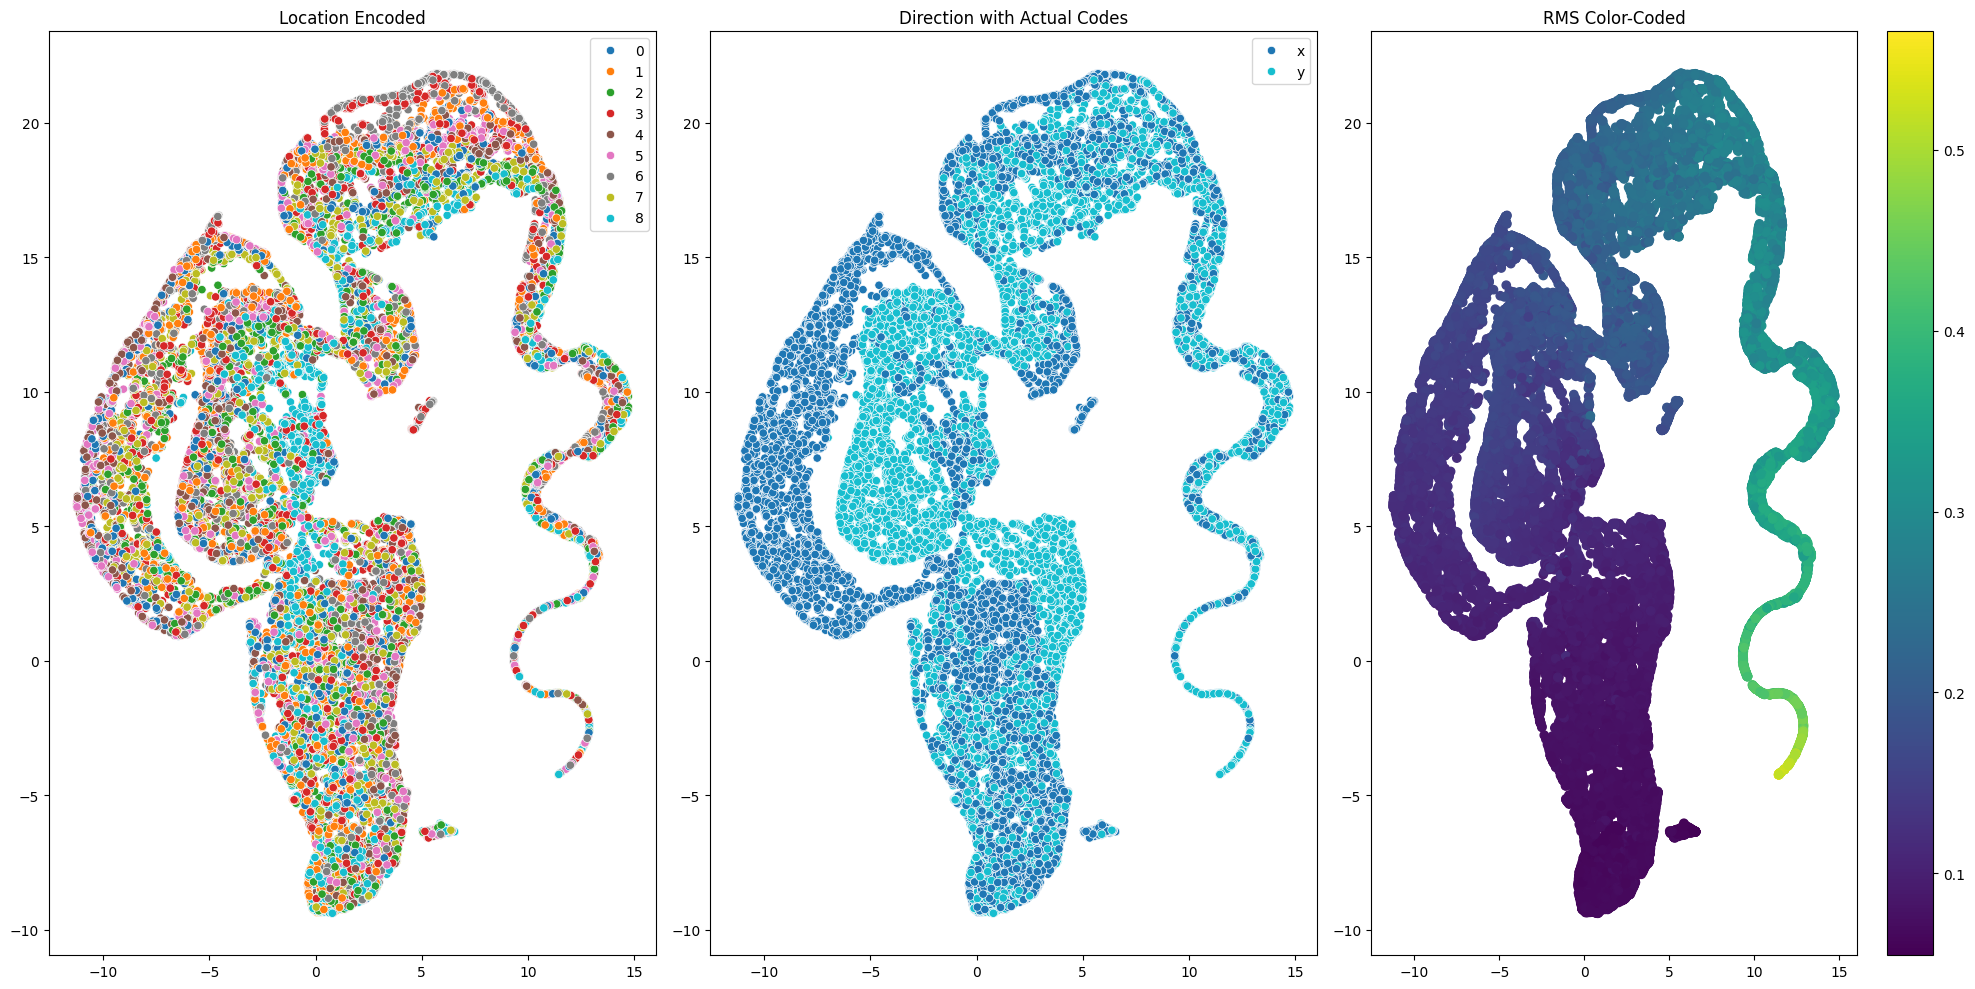

In [132]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns

# Define unique categories for location and direction
unique_locations = np.unique(level_labels)
unique_directions = np.unique(direction_labels)

# Use a predefined colormap from matplotlib
location_cmap = plt.get_cmap('tab10', len(unique_locations))  # tab10 for location categories
direction_cmap = plt.get_cmap('tab10', len(unique_directions))  # Blues for direction categories

# Encode categorical variables into numeric values
location_encoded = LabelEncoder().fit_transform(level_labels)
direction_encoded = LabelEncoder().fit_transform(direction_labels)

fig, ax = plt.subplots(1, 3, figsize=(20, 10))

# Plot location-encoded scatter plot
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=location_encoded,
    palette=location_cmap.colors,
    ax=ax[0],
)

# Plot direction-encoded scatter plot, with actual labels in the legend
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    hue=direction_labels,  # Use the actual direction values instead of encoded ones
    hue_order=np.unique(direction_labels),  # Ensure the order is the same as in the data
    palette=direction_cmap.colors,
    ax=ax[1],
)

# Scatterplot with rms and colorbar
scatter = ax[2].scatter(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1],
    c=rms_values,
    cmap='viridis',  # Choose a colormap for rms values
)
cbar = fig.colorbar(scatter, ax=ax[2])  # Add colorbar to the figure for ax[2]

# Set titles for the subplots
ax[0].set_title('Location Encoded')
ax[1].set_title('Direction with Actual Codes')
ax[2].set_title('RMS Color-Coded')

plt.tight_layout()
plt.show()


In [133]:
import torch
import torch.nn as nn

class Detector(nn.Module):
    def __init__(self, model, sensor_mask):
        super().__init__()
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        self.sensor_mask = sensor_mask  # List of sensor indices to provide


    def compute_reconstruction_error(self, x):
        with torch.no_grad():
            # Move input to device
            x = x.to(self.device)

            # Forward pass with specified sensor_mask
            x_reconstructed, mask = self.model(x, sensor_mask=self.sensor_mask)

            # Compute reconstruction error on masked sensors
            reconstruction_error = (x_reconstructed - x) ** 2  # [B, S, F]

            # Collect errors for masked sensors
            mse = torch.mean(reconstruction_error,dim=2)

        return mse.cpu()

    def forward(self, x):
        return self.compute_reconstruction_error(x)


In [134]:
from torch.utils.data import Dataset, DataLoader, random_split, default_collate
import sqlite3
import pytorch_lightning as pl
import torch
import numpy as np
def custom_collate_fn(batch):
    """
    Custom collate function to properly batch dictionary-like outputs
    from the PSDDataset.
    """
    # Initialize a dictionary to hold batched data
    batched = {key: [] for key in batch[0].keys()}
    for item in batch:
        for key, value in item.items():

            batched[key].append(value)

    return batched


class PSDDataset(Dataset):
    def __init__(self, db_path, query_key, columns, transform_func=None, return_dict=False):
        self.db_path = db_path
        self.query_key = query_key
        self.columns = columns
        self.transform_func = transform_func or [lambda x: x] * len(columns)
        self.return_dict = return_dict

        # Fetch all unique dates based on the query_key
        with sqlite3.connect(self.db_path) as conn:
            c = conn.cursor()
            self.dates = c.execute(self.query_key).fetchall()
            self.dates = [date[0] for date in self.dates]

    def __len__(self):
        return len(self.dates)

    def __getitem__(self, idx):
        # Get all PSDs for a specific date
        date = self.dates[idx]
        query = f'''
            SELECT {", ".join(self.columns)}
            FROM data
            WHERE date = ?
            AND sensor = "accel"
            AND corrupted = 0
        '''

        with sqlite3.connect(self.db_path) as conn:
            c = conn.cursor()
            rows = c.execute(query, (date,)).fetchall()

        # Transform each column
        transformed = [
            [func(row[i]) for row in rows]
            for i, func in enumerate(self.transform_func)
        ]
        # stack the first dimension
        transformed[0] = torch.stack(transformed[0])

        if self.return_dict:
            return {col: transformed[i] for i, col in enumerate(self.columns)}
        else:
            return transformed


class PSDDataModule(pl.LightningDataModule):
    def __init__(self, db_path, query_key, columns, transform_func=None, batch_size=32, num_workers=4, return_dict=False):
        super().__init__()
        self.db_path = db_path
        self.query_key = query_key
        self.columns = columns
        self.transform_func = transform_func or [lambda x: x] * len(columns)
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.return_dict = return_dict
        self.dataset = None

    def setup(self, stage=None):
        self.dataset = PSDDataset(
            db_path=self.db_path,
            query_key=self.query_key,
            columns=self.columns,
            transform_func=self.transform_func,
            return_dict=self.return_dict
        )

        dataset_size = len(self.dataset)
        train_size = int(0.8 * dataset_size)
        val_size = dataset_size - train_size

        self.train_dataset, self.val_dataset = random_split(
            self.dataset, [train_size, val_size]
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            collate_fn=custom_collate_fn
        )

    def val_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=custom_collate_fn
        )
    def all_dataloader(self):
        return DataLoader(
            self.dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            collate_fn=custom_collate_fn
        )

In [135]:
import pandas as pd
sensor_mask = [17]  # Index of the final sensor (e.g., sensor 17 for 18 sensors)

# Initialize the Detector with the model and sensor_mask
detector = Detector(model, sensor_mask=sensor_mask)

# Prepare your data loader for testing
# Assuming 'data_loader' is set up properly
columns = ['psd','date', 'level', 'direction']
transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150)), NormLayer(max_val=4.96, min_val=-5.46, denormalize=False)),
    nn.Identity(),
    nn.Identity(),
    nn.Identity()
]
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = f'''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
    ORDER BY date
'''
data_loader_test = PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=20000,
    return_dict=True,
)
data_loader_test.setup()

# Collect reconstruction errors
df_res = pd.DataFrame(columns=['date', 'mse', 'direction', 'level'])

for batch in data_loader_test.all_dataloader():
    psds = torch.stack(batch['psd'])
    dates = np.stack(batch['date'])
    directions = np.stack(batch['direction'])
    levels = np.stack(batch['level'])

    # Compute reconstruction error
    mse = detector(psds)

    # Create a DataFrame with the results
    # squeez the mse tensor 
    mse = mse.squeeze(-1).numpy().flatten()
    levels = np.squeeze(levels).flatten()
    directions = np.squeeze(directions).flatten()
    dates = dates.flatten()
    
    df_temp = pd.DataFrame({'date': dates, 'mse': mse, 'direction': directions, 'level': levels})
    df_res = pd.concat([df_res, df_temp], axis=0)

/tmp/ipykernel_4017984/3640225338.py:54: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_res = pd.concat([df_res, df_temp], axis=0)


In [136]:
events = settings.state.to_dict()

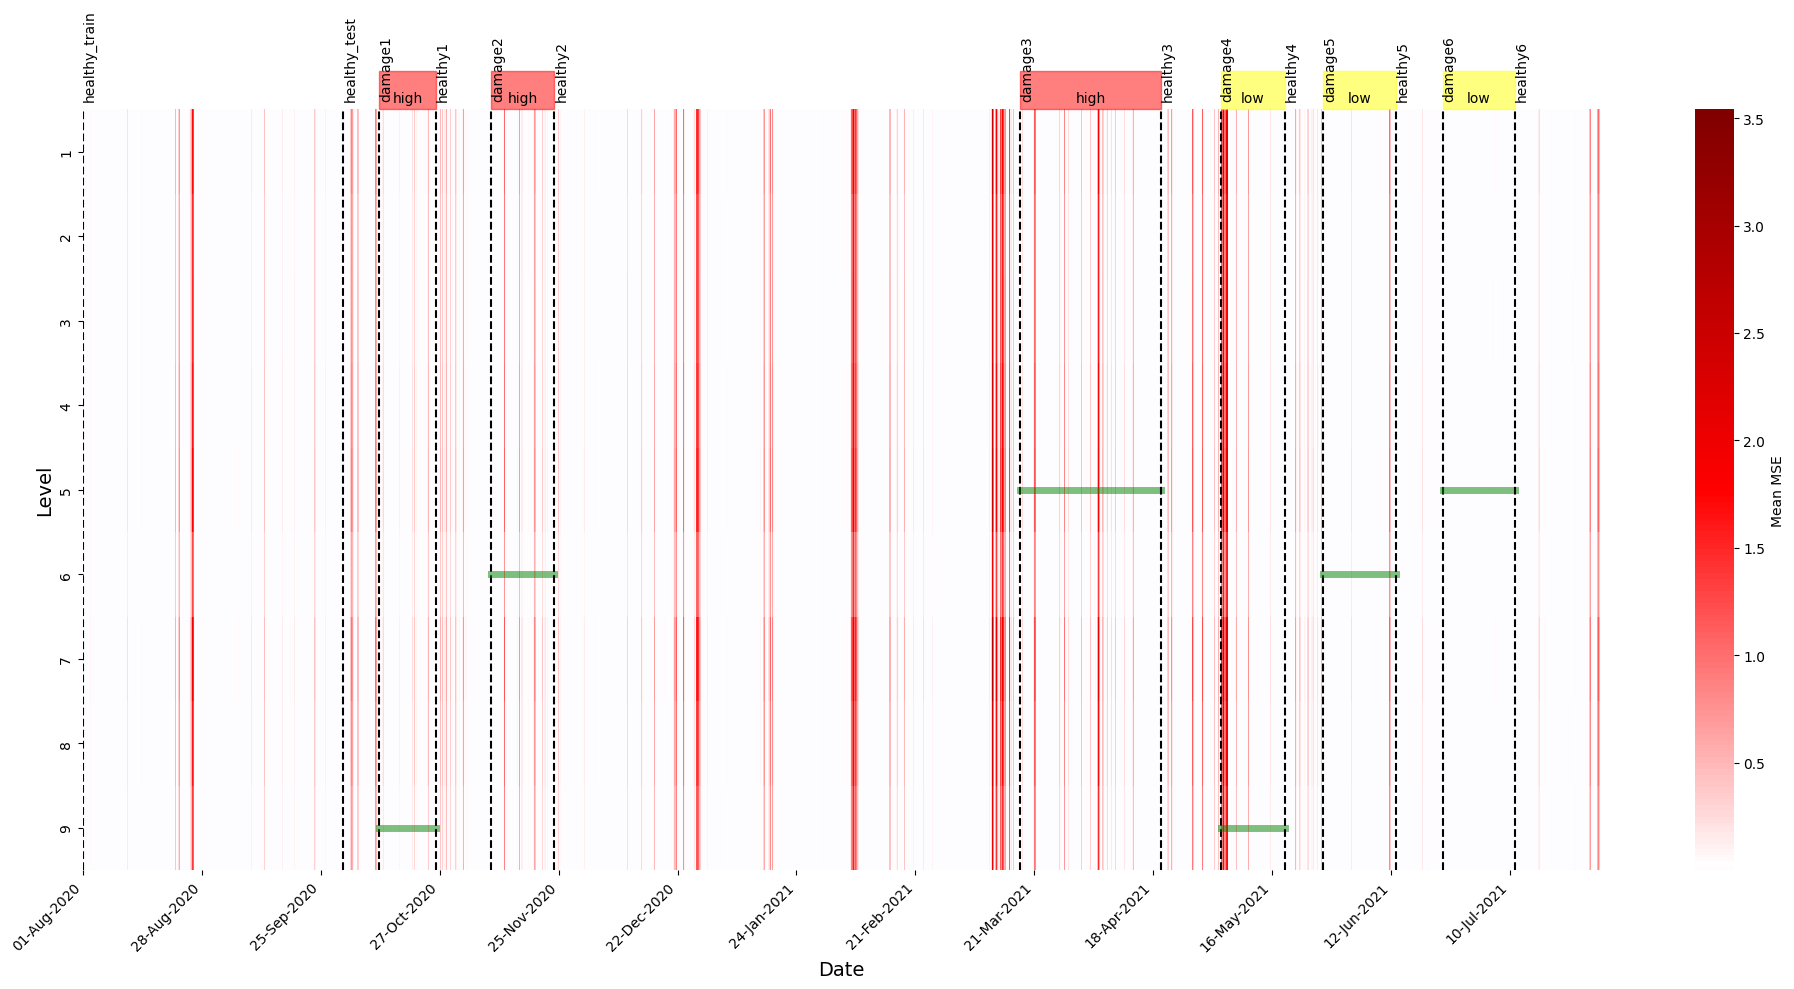

In [137]:
from matplotlib.ticker import FuncFormatter

def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)

# Apply the custom date formatter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial

# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 'y']
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='mse', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'Mean MSE'},  # Add a color bar label
    ax=ax,
    center=0.001

)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()


In [38]:
# train a normal autoencoder with convolutional layers and where each sensor is treated as a channel
import torch
from torch import nn
import torch.nn.functional as F



class ConvAutoencoder(nn.Module):
    def __init__(self, num_sensor: int):
        super(ConvAutoencoder, self).__init__()
        self.num_sensor = num_sensor

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=num_sensor, out_channels=16, kernel_size=10, stride=5),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=8, stride=4),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=6, stride=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(in_channels=64, out_channels=128, kernel_size=4, stride=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(in_channels=128, out_channels=16, kernel_size=10, stride=1)  # Smaller latent space
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=16, out_channels=128, kernel_size=10, stride=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=128, out_channels=64, kernel_size=4, stride=2, output_padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=64, out_channels=32, kernel_size=6, stride=3, output_padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=32, out_channels=16, kernel_size=8, stride=4, output_padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=16, out_channels=num_sensor, kernel_size=10, stride=5, output_padding=0)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
class NormalReconstruction(pl.LightningModule):
    def __init__(self,num_sensor:int,lr:float):
        super(NormalReconstruction, self).__init__()
        self.model = ConvAutoencoder(num_sensor)
        self.lr = lr
    def forward(self,x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

        
model = NormalReconstruction(num_sensor=18, lr=1e-3)

# 4. Use your existing data module (data_module) for data loading
# Assuming 'data_module' is already set up as in your previous code

# 5. Train the model using the PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)
        
    
        
    
    
        
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | ConvAutoencoder | 146 K  | train
--------------------------------------------------
146 K     Trainable params
0         Non-trainable params
146 K     Total params
0.586     Total estimated model params size (MB)
29        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 1277/1277 [00:24<00:00, 51.58it/s, v_num=98, train_loss_step=0.000464, val_loss_step=0.000847, val_loss_epoch=0.000978, train_loss_epoch=0.000956]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1277/1277 [00:24<00:00, 51.56it/s, v_num=98, train_loss_step=0.000464, val_loss_step=0.000847, val_loss_epoch=0.000978, train_loss_epoch=0.000956]


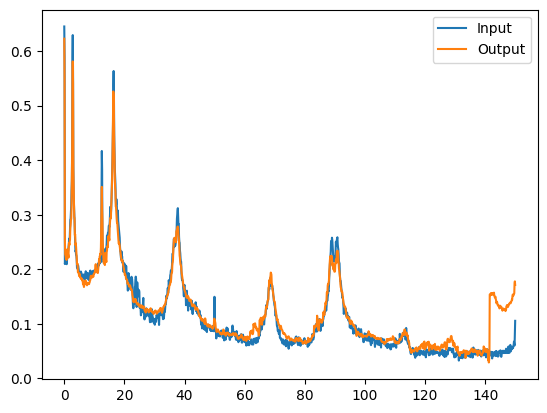

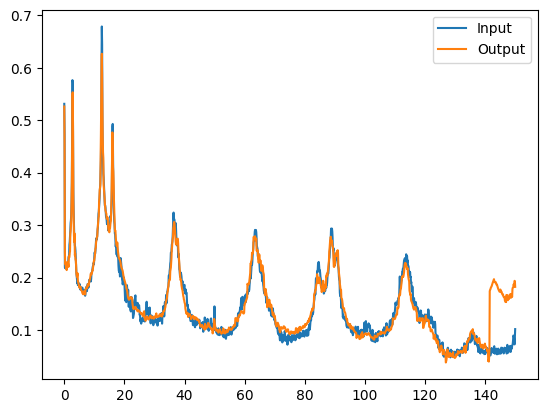

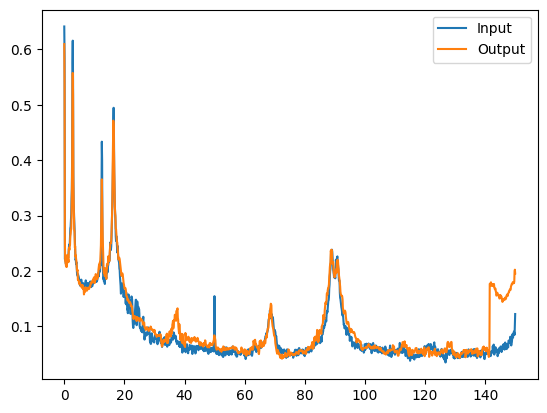

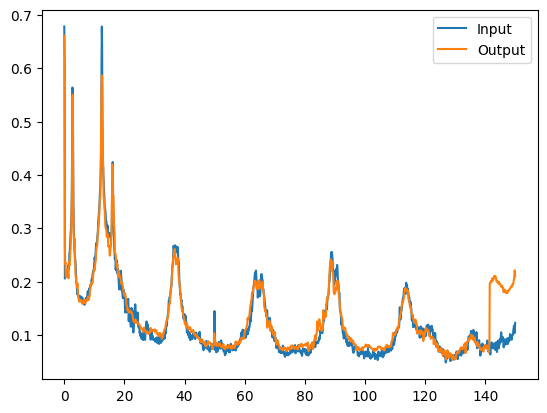

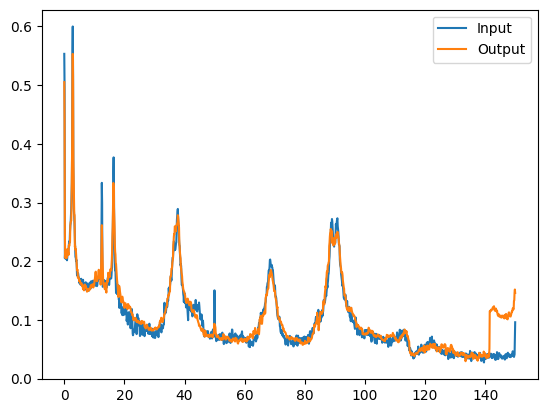

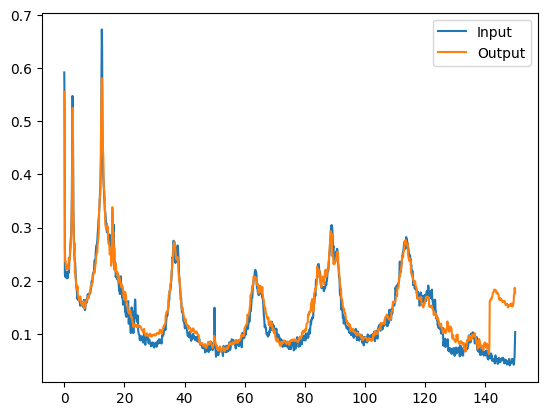

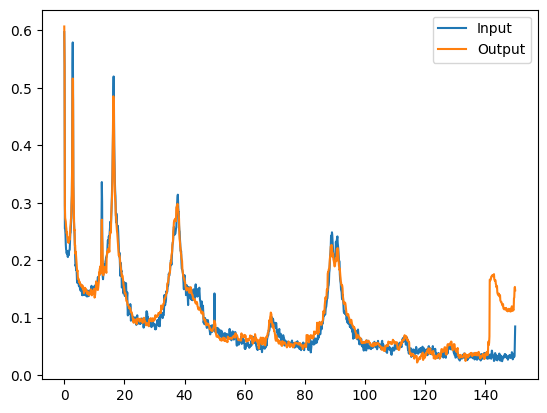

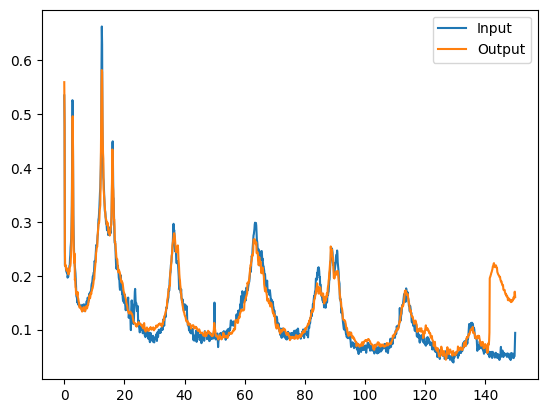

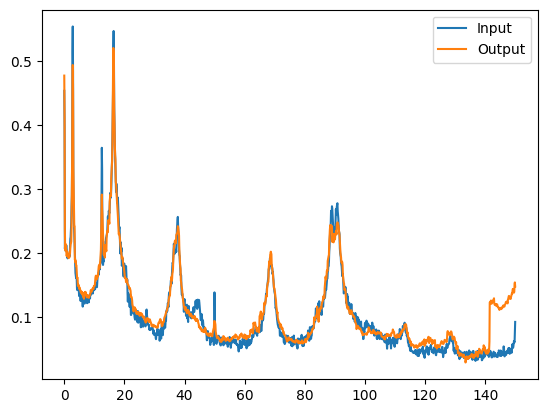

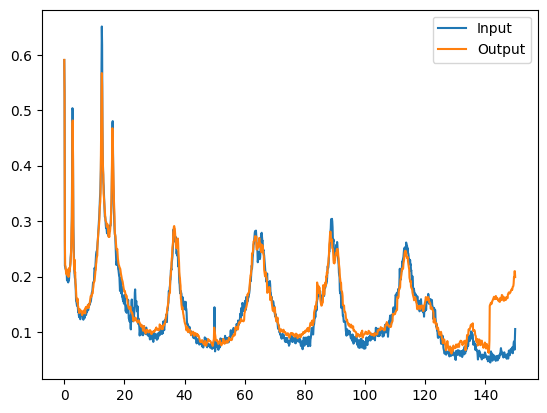

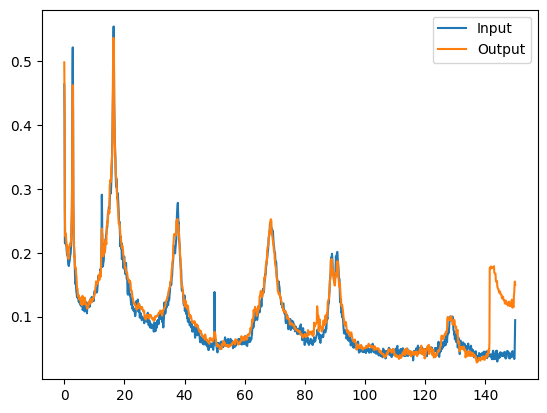

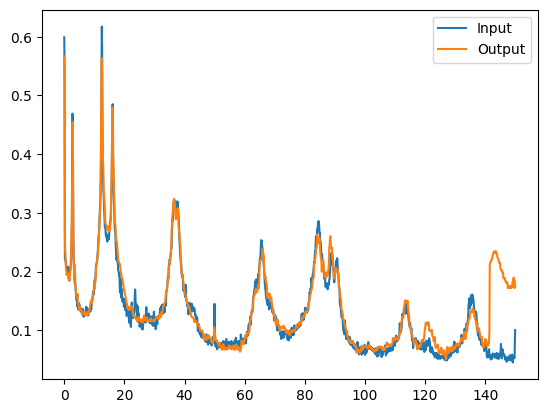

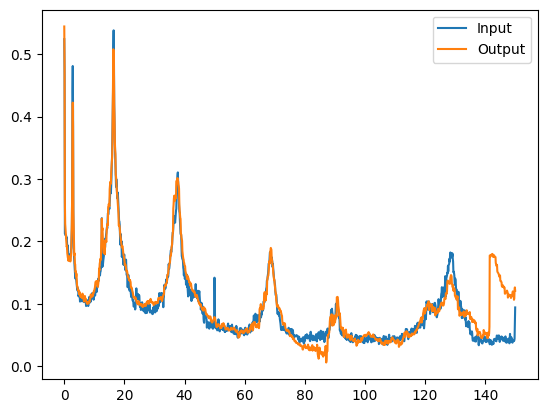

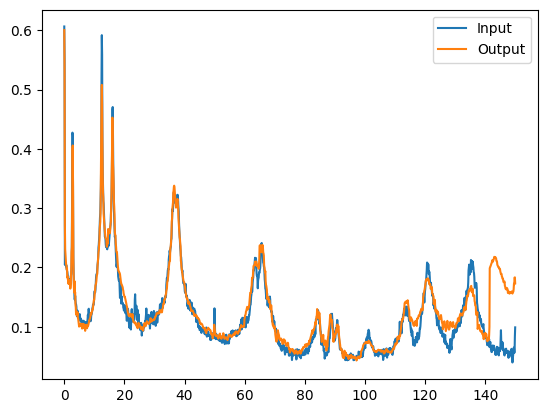

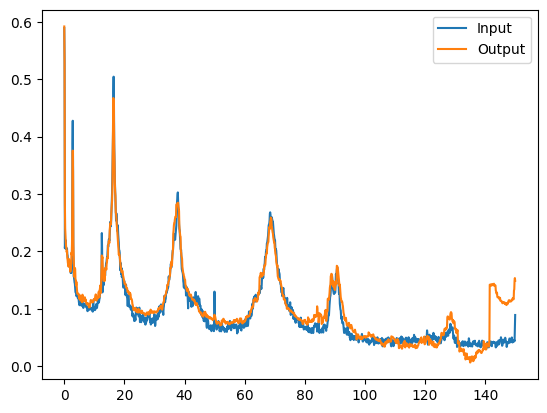

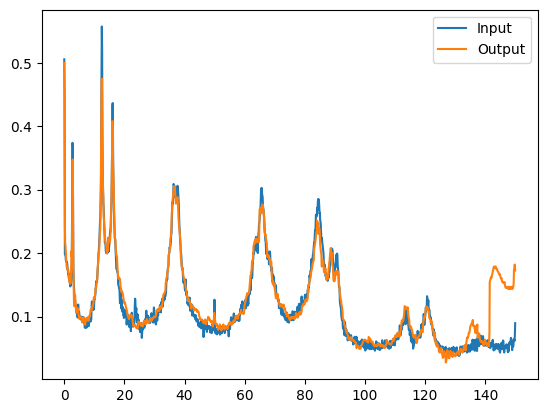

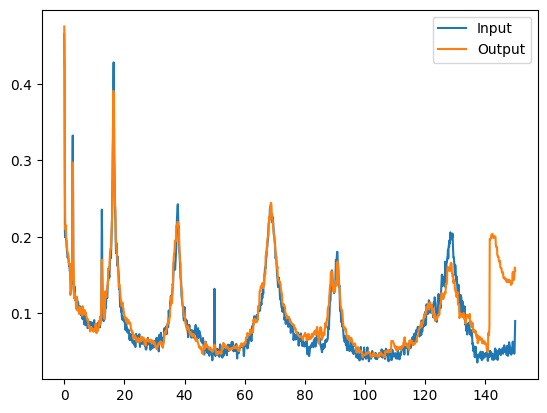

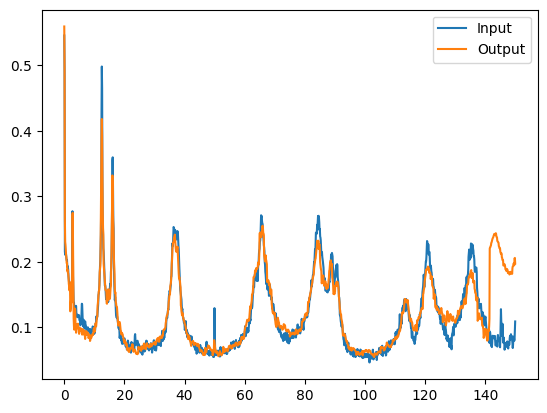

In [39]:
model.eval()
# Get a batch of data

batch = next(iter(data_module.val_dataloader()))
psd_in = torch.stack(batch['psd'])
psd_out = model(psd_in)
psd_in = psd_in[5]
psd_out = psd_out[5]

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:input_dim], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:input_dim], psd_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()

In [64]:
# check the embeddings of the autoencoder as we did with the transformer
import torch
import numpy as np
from hannover_pylon.data import datamodules as dm_no_pivot

# Ensure the model is in evaluation mode
model.eval()

embedding= []
level = []
direction = []
rms = []
for batch in data_module.val_dataloader():
    x = torch.stack(batch['psd']).to(model.device)
    with torch.no_grad():
        embedding_batch = model.model.encoder(x).cpu().numpy()
    embedding.append(embedding_batch)
    level.extend(batch['level'])
    direction.extend(batch['direction'])
    rms.append(torch.sqrt(torch.mean(x**2, dim=-1)).detach().cpu().numpy()[0])


In [65]:
rms = np.concatenate(rms, axis=0)

In [66]:
embedding = np.concatenate(embedding, axis=0)

In [67]:
embedding = embedding.reshape(embedding.shape[0],-1)

In [68]:
embedding.shape

(10210, 16)

In [69]:
import umap
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(embedding)




<Axes: >

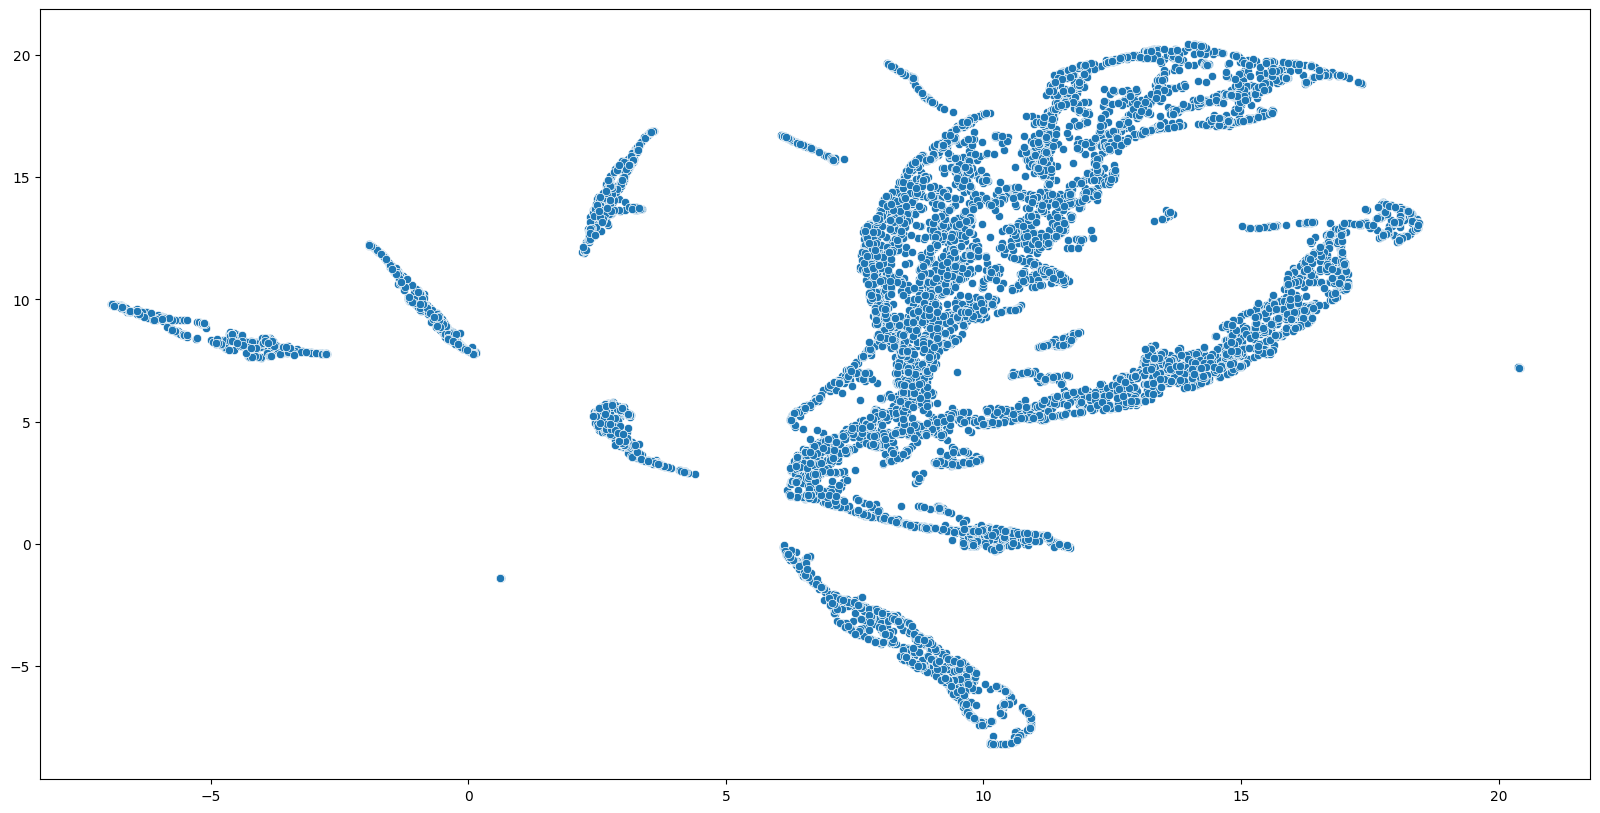

In [70]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.preprocessing import LabelEncoder
import numpy as np
import seaborn as sns




fig, ax = plt.subplots( figsize=(20, 10))

# Plot location-encoded scatter plot
sns.scatterplot(
    x=embedding_umap[:, 0],
    y=embedding_umap[:, 1])

In [71]:
columns = ['psd', 'date', 'level', 'direction']
transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150)), NormLayer(max_val=4.96, min_val=-5.46, denormalize=False)),
    nn.Identity(),
    nn.Identity(),
    nn.Identity()
]
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = '''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
    ORDER BY date
'''
data_module_test = PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=32,
    return_dict=True,
)
data_module_test.setup()


In [82]:
class Detector(nn.Module):
    def __init__(self,model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        
    def forward(self,x):
        with torch.no_grad():
            x = x.to(self.device)
            x_reconstructed = self.model(x)
            reconstruction_error = (x_reconstructed - x)**2
            mse = torch.quantile(reconstruction_error,dim=2,q=0.95)
        return mse.cpu()
    

In [88]:
columns = ['psd','date', 'level', 'direction']
transform_func = [
    nn.Sequential(FromBuffer(), CutPSD(freq_axis=freq_axis, freq_range=(0, 150)), NormLayer(max_val=4.96, min_val=-5.46, denormalize=False)),
    nn.Identity(),
    nn.Identity(),
    nn.Identity()
]
db_path = Path(settings.path.processed, 'Welch(n_fft=16392, fs=1651, max_freq=825.5).db')
query_key = f'''
    SELECT DISTINCT date
    FROM data
    WHERE sensor = "accel"
    AND corrupted = 0
    ORDER BY date
'''
data_loader_test = PSDDataModule(
    db_path=db_path,
    columns=columns,
    transform_func=transform_func,
    query_key=query_key,
    batch_size=25000,
    return_dict=True,
)
data_loader_test.setup()

In [89]:
import pandas as pd

# Initialize the Detector with the trained model
detector = Detector(model)

# Collect reconstruction errors
df_res = []
for batch in data_module_test.all_dataloader():
    psds = torch.stack(batch['psd'])  # [B, num_sensors, input_dim]
    dates = batch['date']
    directions = batch['direction']
    levels = batch['level']

    # Compute reconstruction error
    mse = detector(psds)
    mse = mse.squeeze(-1).numpy().flatten()
    dates = np.array(dates).flatten()
    directions = np.array(directions).flatten()
    levels = np.array(levels).flatten()
    
    df_temp = pd.DataFrame({'date': dates, 'mse': mse, 'direction': directions, 'level': levels})
    df_res.append(df_temp)
    

In [75]:
df_res = pd.concat(df_res, axis=0)

In [76]:
events = settings.state.to_dict()

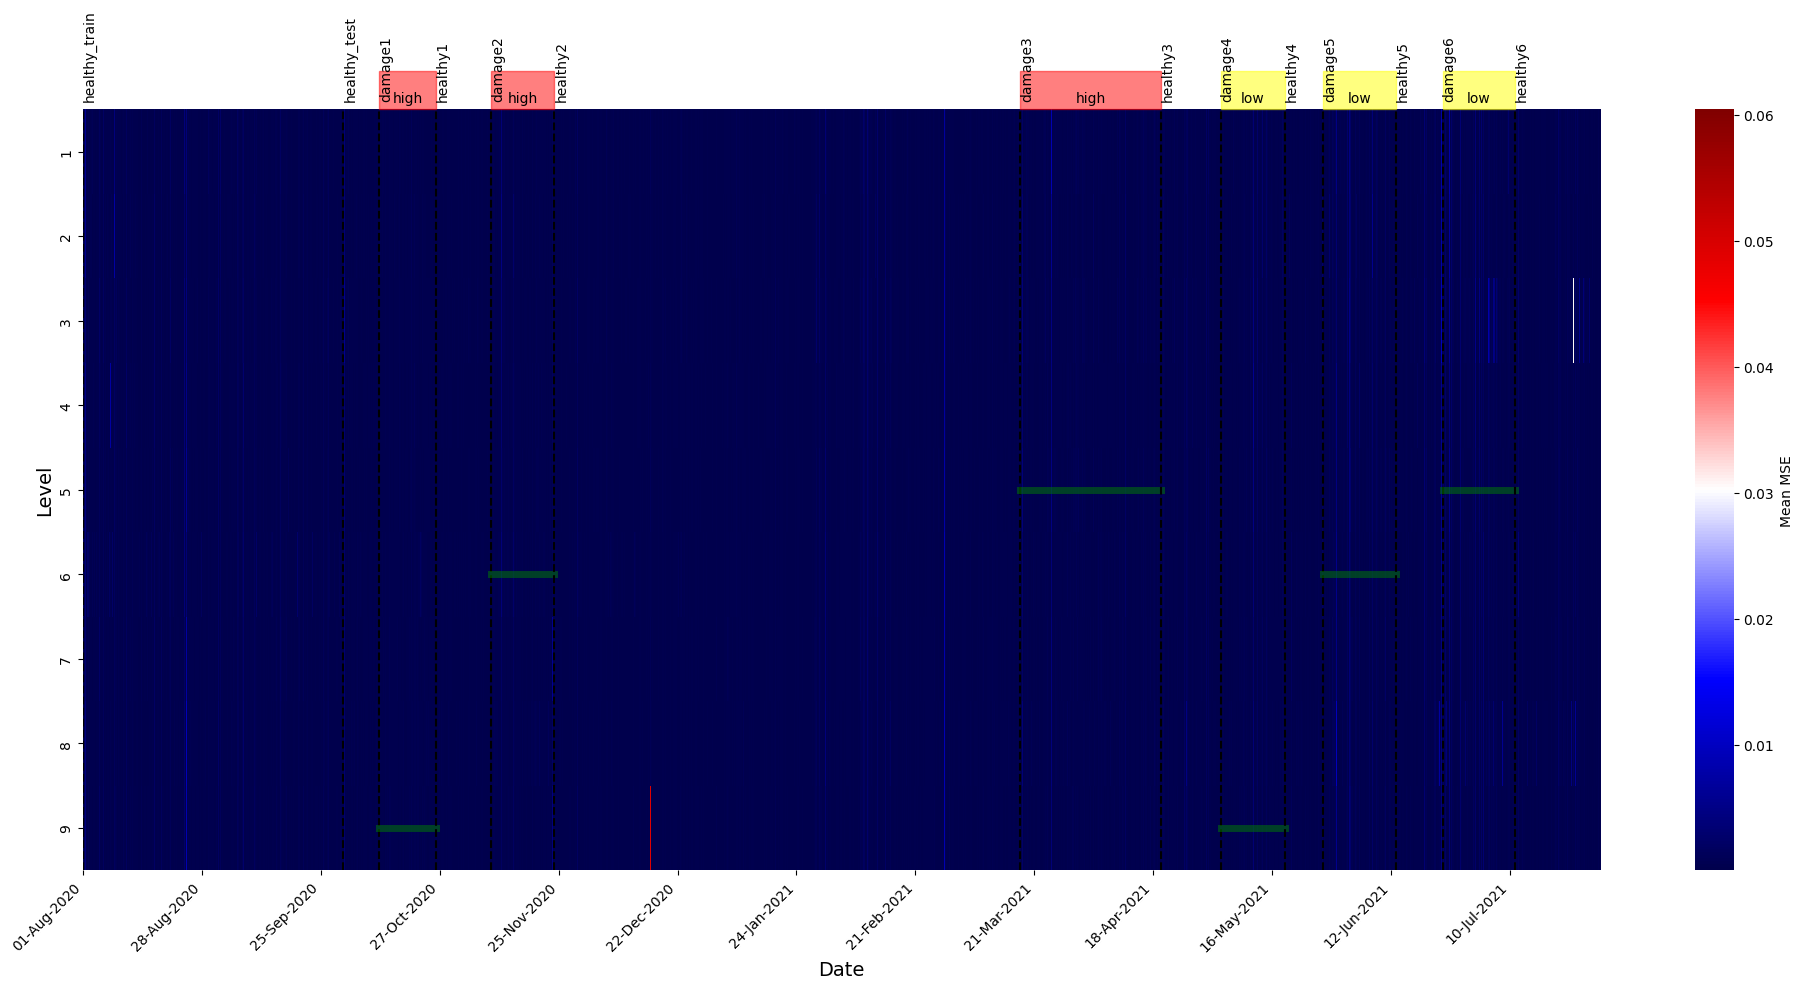

In [81]:
from matplotlib.ticker import FuncFormatter

def create_date_formatter(column_dates):
    """Return a custom formatter function for datetime labels."""
    def custom_date_format(x, pos=None):
        if 0 <= int(x) < len(column_dates):
            return column_dates[int(x)].strftime('%d-%b-%Y')
        return ''  # Return empty string if out of range
    return FuncFormatter(custom_date_format)

# Apply the custom date formatter

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator
from matplotlib.patches import Rectangle
import pandas as pd
import numpy as np
from functools import partial

# Filter the dataframe for 'y' direction and pivot the data for the heatmap
df_res['date'] = pd.to_datetime(df_res['date'])
df_res_y = df_res[df_res['direction'] == 'y']
df_pivot = df_res_y.pivot_table(index='level', columns=['date'], values='mse', aggfunc='mean')
# average the mse over 1hours rolling window with 1 hour step
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

# Plot the heatmap with seaborn
df_pivot.columns = pd.to_datetime(df_pivot.columns)

sns.heatmap(
    df_pivot, 
    cmap='seismic',  # Set the color map to 'seismic' for highlighting extremes
    cbar_kws={'label': 'Mean MSE'},  # Add a color bar label
    ax=ax,
    center=0.1

)
# Set axis labels and title
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Level', fontsize=14)
ax.xaxis.set_major_formatter(create_date_formatter(df_pivot.columns))
ax.xaxis.set_major_locator(MaxNLocator(nbins=15))  # Set the maximum number of ticks

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

for event_i in events:
    start = pd.to_datetime(events[event_i]['start'])
    end = pd.to_datetime(events[event_i]['end'])
    idx_start = np.cumsum(df_pivot.columns < start)[-1]
    idx_end = np.cumsum(df_pivot.columns < end)[-1]
    
    # Draw vertical line and label for event
    ax.axvline(idx_start, color='black', linestyle='--', label=f'{event_i} start')
    ax.text(idx_start, -0.1, f'{event_i}', rotation=90, va='bottom', ha='left')
    
    # Draw horizontal line for the closest sensor level during the event
    level = events[event_i].get('closest_sensor', None)
    if level is not None:
        ax.axhline(level - 0.5, xmin=idx_start / len(df_pivot.columns), xmax=idx_end / len(df_pivot.columns), 
                   color='green', linestyle='-', lw=5, alpha=0.5)
    
    # Draw a box above the plot to indicate severity
    severity = events[event_i].get('severity', None)
    if severity is not None:
        color = 'red' if severity == 'high' else 'yellow'
        # Add rectangle patch above the plot to indicate severity
        box_height = 0.05  # Height of the box
        ax.add_patch(Rectangle(
            (idx_start, 1),  # Starting point of the box (above the plot)
            width=idx_end - idx_start,                # Width of the box
            height=box_height,                        # Height of the box
            color=color, 
            alpha=0.5,
            transform=ax.get_xaxis_transform(),       # Transform to place above the x-axis
            clip_on=False                             # Make sure the rectangle is not clipped
        ))
        ax.text((idx_start + idx_end) / 2, -0.1+ box_height, severity, ha='center', va='bottom', color='black')
# Tighten the layout
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
class DenseAutoencoder(nn.Module):
    def __init__(self, num_sensors: int, input_size: int, latent_dim: int):
        super(DenseAutoencoder, self).__init__()
        self.num_sensors = num_sensors
        self.input_size = input_size
        self.input_dim = num_sensors * input_size
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Flatten(),  # Flatten the input
            nn.Linear(self.input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)  # Latent space
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, self.input_dim),
            nn.Sigmoid()  # Output as flattened data
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.view(-1, self.num_sensors, self.input_size)  # Reshape back to [B, num_sensors, time_steps]
        return x

In [79]:
class NormalReconstruction(pl.LightningModule):
    def __init__(self,input_dim:int,num_sensor:int,lr:float):
        super(NormalReconstruction, self).__init__()
        self.model = DenseAutoencoder(num_sensor,input_dim,16)
        self.lr = lr
    def forward(self,x):
        return self.model(x)
        
    def training_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('train_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x = torch.stack(batch['psd'])  # x shape: [B, num_sensors, input_dim]
        x_reconstructed = self(x)
        loss = F.mse_loss(x_reconstructed, x)
        self.log('val_loss', loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

        
model = NormalReconstruction(1490,num_sensor=18, lr=1e-3)

# 4. Use your existing data module (data_module) for data loading
# Assuming 'data_module' is already set up as in your previous code

# 5. Train the model using the PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20)
trainer.fit(model, data_module)
        

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | Mode 
---------------------------------------------------
0 | model | DenseAutoencoder | 6.9 M  | train
---------------------------------------------------
6.9 M     Trainable params
0         Non-trainable params
6.9 M     Total params
27.646    Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 1277/1277 [00:21<00:00, 58.21it/s, v_num=100, train_loss_step=0.000155, val_loss_step=0.000149, val_loss_epoch=0.00018, train_loss_epoch=0.000181] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 1277/1277 [00:22<00:00, 57.83it/s, v_num=100, train_loss_step=0.000155, val_loss_step=0.000149, val_loss_epoch=0.00018, train_loss_epoch=0.000181]


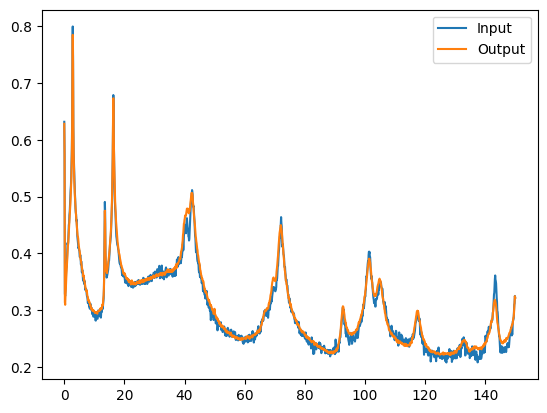

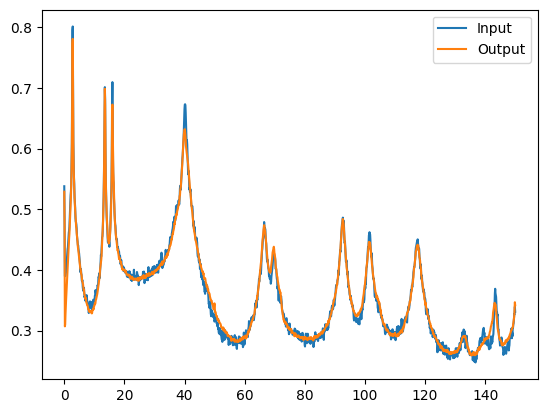

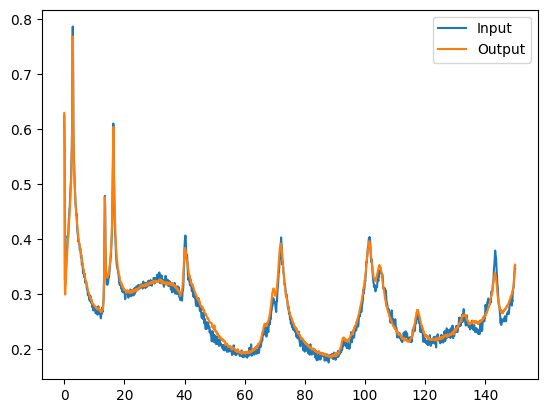

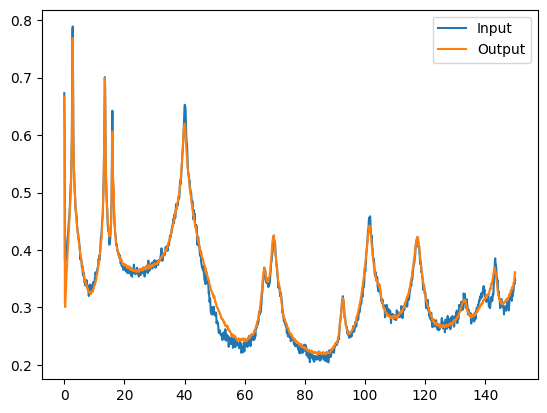

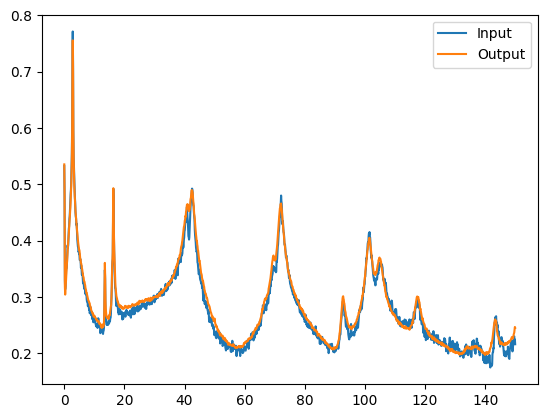

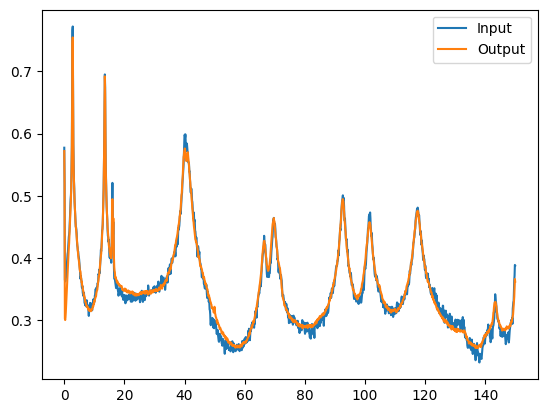

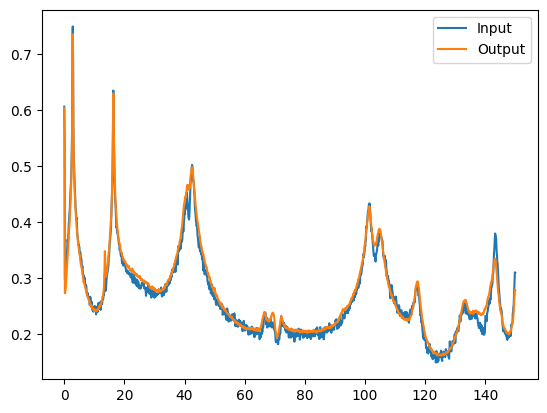

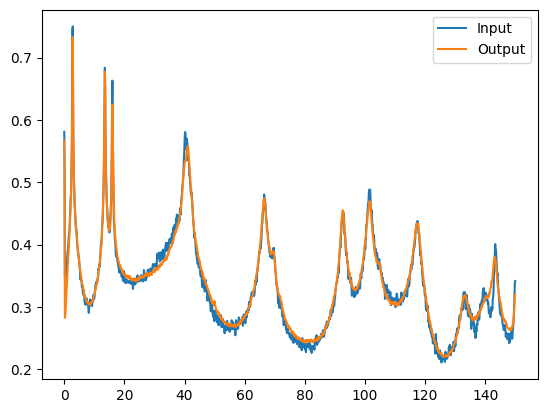

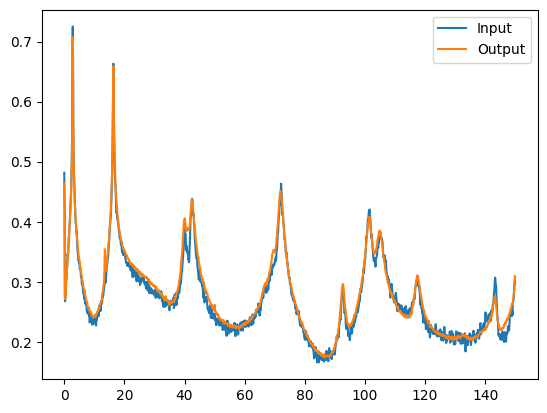

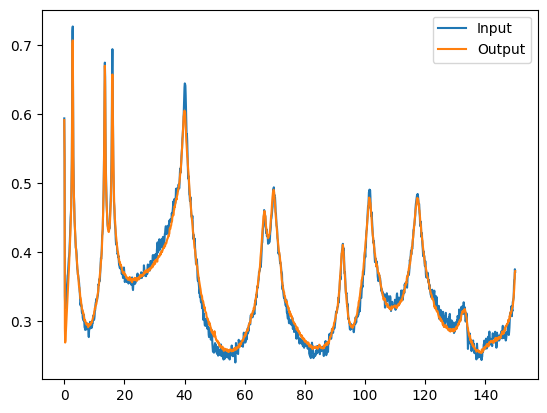

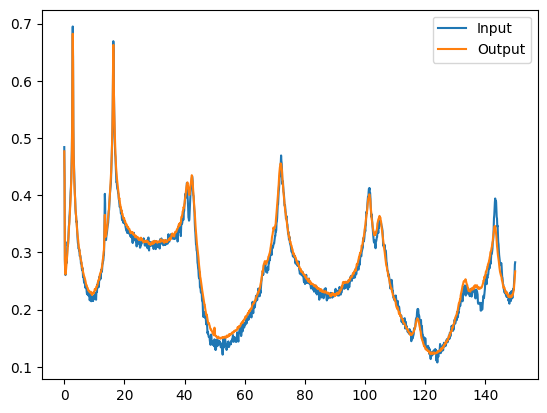

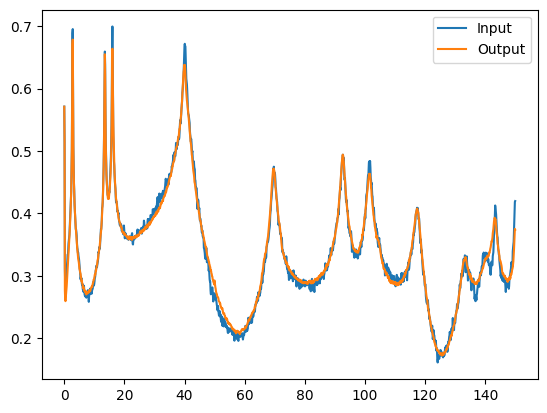

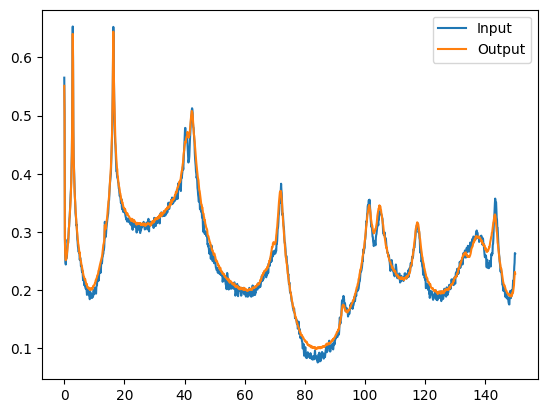

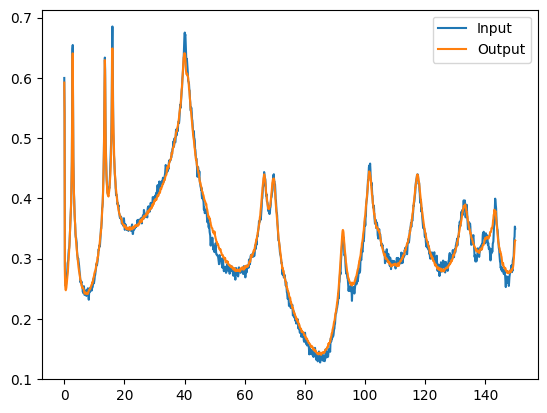

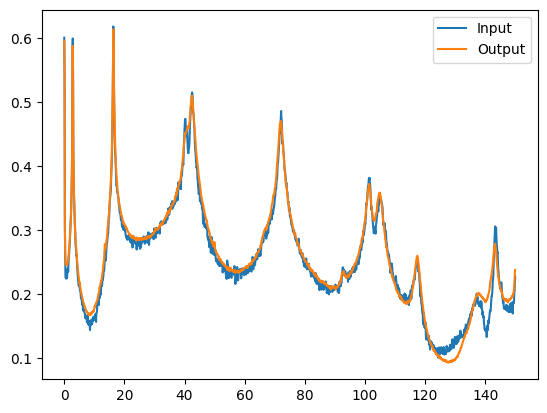

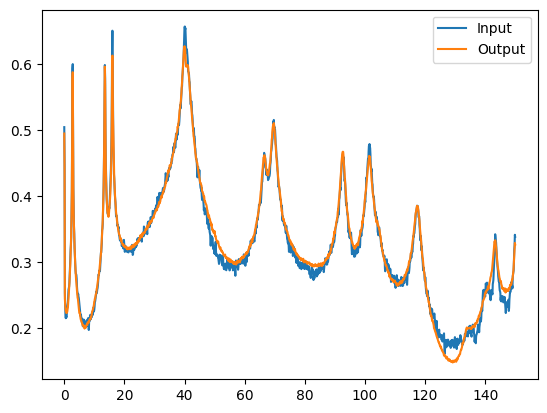

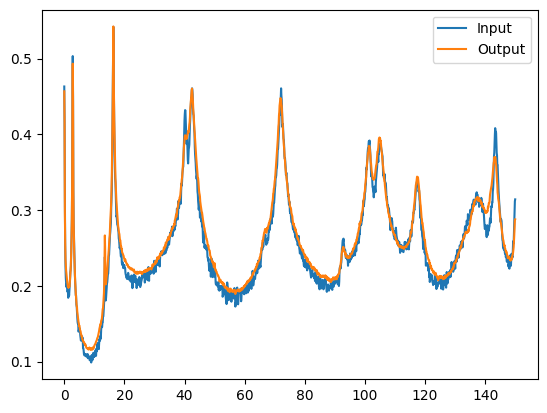

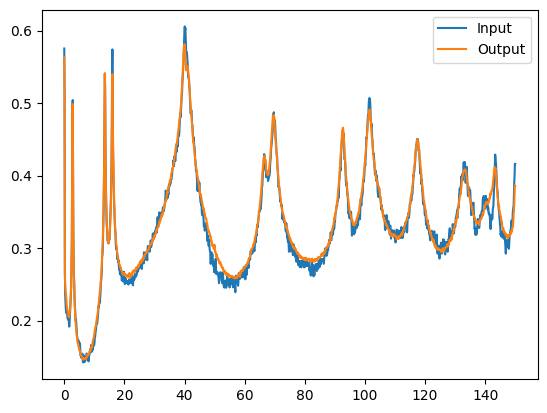

In [80]:
model.eval()
# Get a batch of data

batch = next(iter(data_module.val_dataloader()))
psd_in = torch.stack(batch['psd'])
psd_out = model(psd_in)
psd_in = psd_in[5]
psd_out = psd_out[5]

for i in range(18):
    plt.figure()
    plt.plot(freq_axis[0:input_dim], psd_in[i].detach().numpy(), label='Input')
    plt.plot(freq_axis[0:input_dim], psd_out[i].detach().numpy(), label='Output')
    plt.legend()
    plt.show()
    plt.close()